In [862]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

### Calculate (future) ACE from forecasts of a single intensity model using cyclone a-tracks
### Uses linear interpolation to get values of 6h intervals

# This notebook has become a bit of a sprawling mess, using it for different questions; no motivation to clean it up...

# download latest a-tracks manually for basin of interest (no automation yet)
# and change names of atrack files below

# note: make sure to gunzip them
# https://ftp.nhc.noaa.gov/atcf/aid_public/?C=M;O=D
    
### DOWNLOAD LATEST ATRACKS AND UPDATE THE FOLLOWING TWO VARIABLES EVERY RUN OF THE NOTEBOOK
atrack_files = [
    #'aal162024.dat'
]

# latest real time ACE (for North Atlantic)
# from http://tropical.atmos.colostate.edu/Realtime/
# Updated 21 MT (+6=03 UTC)
#real_time_ACE = 73.8
#real_time_ACE = 94.7
#real_time_ACE = 108.3
#real_time_ACE = 87.8
real_time_ACE = 145.3
# fudge factor for a single storm that might be over/underestimated
selected_storm_id = "AL12"
selected_storm_ace = 0.0

#### specify end of real time ACE (UTC), or the latest time of which there would be expected no TC genesis
#### this will be adjusted to last forecast valid time if there are atracks
#ace_time_end_str = "2024-09-28 15:00:00"
ace_time_end_str = "2024-10-12 15:00:00"
ace_time_end_str = "2024-10-30 00:00:00"
ace_time = datetime.fromisoformat(ace_time_end_str)

#min_year = 1851
min_year = 1966

# Note: this auto-tunes an expotential decay parameter for expected ACE using MSE.
# Make sure to:
#   1) Check the difference of MSE in the validation
#   2) Check to make sure that the "Rate final tuning" is within the bounds of the rates tried

# Update: Oct 22: Since the last few days the exponential decay validates poorly and is no longer robust
#   Will use second predictor even though it has only 16 samples

In [863]:
##### CONFIG BASIN AND INTENSITY MODEL
match_basin = 'AL'
# consensus model
match_model = 'OFCL'

In [864]:
ab_column_names = [
    'BASIN',
    'CY',
    'YYYYMMDDHH',
    'TECHNUM/MIN',
    'TECH',
    'TAU',
    'LatN/S',
    'LonE/W',
    'VMAX',
    'MSLP',
    'TY',
    'RAD',
    'WINDCODE',
    'RAD1',
    'RAD2',
    'RAD3',
    'RAD4',
    'POUTER',
    'ROUTER',
    'RMW',
    'GUSTS',
    'EYE',
    'SUBREGION',
    'MAXSEAS',
    'INITIALS',
    'DIR',
    'SPEED',
    'STORMNAME',
    'DEPTH',
    'SEAS',
    'SEASCODE',
    'SEAS1',
    'SEAS2',
    'SEAS3',
    'SEAS4',
    'USERDEFINED1',
    'userdata1',
    'USERDEFINED2',
    'userdata2',
    'USERDEFINED3',
    'userdata3',
    'USERDEFINED4',
    'userdata4',
    'USERDEFINED5',
    'userdata5'
]

In [865]:
track_line_lists = []

# read the tracks
for atrack_file in atrack_files:
    with open(atrack_file, 'r') as file:
        lines = file.readlines()
    for line in lines:
        line_list = line.split(',')
        line_list_trim = [x.strip() for x in line_list]
        line_list_trim_rempty = line_list_trim
        
        # trim empty columns on right
        # a tracks have an extra comma before EOL for some reason (should have max 45 columns)
        line_list_trim_rempty.reverse()
        line_list_trim_empty = []
        for [i, v] in enumerate(line_list_trim_rempty):
            if v:
                line_list_trim_empty = line_list_trim_rempty[i:]
                break
        line_list_trim_empty.reverse()
        # convert init time strings to timestamp format
        line_list_trim_empty[2] = datetime.strptime(line_list_trim_empty[2], '%Y%m%d%H')
            
        track_line_lists.append(line_list_trim_empty)

In [866]:
# convert the line lists to a dataframe
df = pd.DataFrame(track_line_lists, columns=ab_column_names)

In [867]:
# get the last matching forecasts
df_match = df.loc[(df['BASIN'] == match_basin) & (df['TECH'] == match_model)]

newest_matching_cyclone_forecast_dfs = []
for cyclone_num in df_match['CY'].unique():
    df_cyclone = df_match.loc[(df['CY'] == cyclone_num)]
    newest_init_time = df_cyclone['YYYYMMDDHH'].max()
    newest_forecast = df_cyclone.loc[(df['YYYYMMDDHH'] == newest_init_time)]
    # make sure these columns are numeric
    # convert to numeric
    col_numeric_names = ["CY", "TAU", "VMAX", "MSLP"]
    for col_numeric_name in col_numeric_names:
        newest_forecast = newest_forecast.astype({col_numeric_name:'int'})
    # drop duplicate forecast lines (34,50,64 lines can create duplicates)
    newest_forecast = newest_forecast.drop_duplicates(subset='TAU', keep='first')
    # drop non-synoptic hour forecast points (OFCL sometimes has 3 hour forecast points)
    newest_forecast = newest_forecast[newest_forecast['TAU'] % 6 == 0]
    # append to list of cyclone forecast dfs
    newest_matching_cyclone_forecast_dfs.append(newest_forecast)

In [868]:
newest_matching_cyclone_forecast_dfs

[]

In [869]:
# interpolate to provide 06 taus
interp_intensity_cyclone_dfs = []

last_valid_time = None

for cyclone_df in newest_matching_cyclone_forecast_dfs:
    forecast_taus = cyclone_df['TAU'].unique()
    min_tau = forecast_taus.min()
    max_tau = forecast_taus.max()
    taus_6h = list(range(min_tau, max_tau + 6, 6))
    taus_missing = []
    for tau in taus_6h:
        if tau not in forecast_taus:
            taus_missing.append(tau)
    for missing_tau in taus_missing:
        # get prev tau
        prev_tau = missing_tau
        while prev_tau >= min_tau:
            prev_tau = prev_tau - 1
            if prev_tau in forecast_taus:
                break
        next_tau = missing_tau
        while next_tau <= max_tau:
            next_tau = next_tau + 1
            if next_tau in forecast_taus:
                break
        prev_intensity = cyclone_df.loc[(cyclone_df['TAU'] == prev_tau)]['VMAX'].values[0]
        next_intensity = cyclone_df.loc[(cyclone_df['TAU'] == next_tau)]['VMAX'].values[0]
        interpolated_intensity = int(round((prev_intensity + next_intensity) / 2.0))
        cyclone_df = cyclone_df.reset_index(drop=True)
        prev_idx = cyclone_df.loc[(cyclone_df['TAU'] == prev_tau)].index.values[0]
        # copy row
        interp_row = cyclone_df.iloc[prev_idx].copy()
        # only manipulate the TAU and INTENSITY so we don't have to copy the rest of the values
        # the long/lat and rest of data have not been interpolated....
        interp_row['TAU'] = missing_tau
        interp_row['VMAX'] = interpolated_intensity
        # add row
        #cyclone_df = cyclone_df.append(interp_row, ignore_index=True)
        cyclone_df = pd.concat([cyclone_df, pd.DataFrame([interp_row])], ignore_index=True)
    cyclone_df = cyclone_df.reset_index(drop=True)
    cyclone_df.sort_values(by=['TAU'], inplace=True)
    cyclone_df = cyclone_df.reset_index(drop=True)
    interp_intensity_cyclone_dfs.append(cyclone_df)
    # cyclone number
    cyclone_num = cyclone_df['CY'].iloc[-1]
    basin = cyclone_df.iloc[-1]['BASIN']
    init_time = cyclone_df.iloc[0]['YYYYMMDDHH']
    min_tau_time = init_time + timedelta(hours=int(min_tau))
    valid_time = init_time + timedelta(hours=int(max_tau))
    # print the forecast times
    print(f"{basin}{cyclone_num}: {min_tau}-{max_tau}H : {min_tau_time} to {valid_time}")
    if last_valid_time == None:
        last_valid_time = valid_time
    if valid_time > last_valid_time:
        last_valid_time = valid_time

print("")
print("Longest forecast covers up until:", last_valid_time)


Longest forecast covers up until: None


In [870]:
# exclude storms less than 35 kt
# exclude forecasts at 00h (since this may already be included in real time ACE)
ACE_min_kt = 35
storm_intensities_above_min = {}
for cyclone_df in interp_intensity_cyclone_dfs:
    cyclone_num = cyclone_df['CY'].iloc[-1]
    basin = cyclone_df.iloc[-1]['BASIN']
    storm_name_str = f'{basin}{cyclone_num}'
    min_kt_rows = cyclone_df.loc[(cyclone_df['VMAX'] >= ACE_min_kt) & (cyclone_df['TAU'] > 0)]['VMAX']
    storm_intensities_above_min[storm_name_str] = list(min_kt_rows.values)

In [871]:
print(storm_intensities_above_min)

{}


In [872]:
forecasts_ace = {}
for [storm_name, vmax] in storm_intensities_above_min.items():
    forecast_storm_ace = (pow(10, -4) * np.sum(np.power(vmax, 2)))
    forecasts_ace[storm_name] = round(forecast_storm_ace,2)

In [873]:
forecast_total_ace = 0
print(f"Future contributions (up until {last_valid_time}) of cyclone ACE values in {match_basin} basin (including INVESTs)\n",
      f"   from latest forecast using {match_model} (excluding 00h) by interpolating intensities")
for [storm_name, ace] in forecasts_ace.items():
    print(f"  ACE(future) for {storm_name} = {ace}")
    if storm_name == selected_storm_id:
        forecast_selected_storm_ace = selected_storm_ace + ace
    forecast_total_ace += ace
print(f"  Total ACE(future): {forecast_total_ace:4.2f}")
total_ace_until_forecast = real_time_ACE + forecast_total_ace
print("")
print("Real-time ACE:", real_time_ACE)
print(f"Total ACE (real-time + forecast) up until {last_valid_time}: {total_ace_until_forecast:.2f}")

Future contributions (up until None) of cyclone ACE values in AL basin (including INVESTs)
    from latest forecast using OFCL (excluding 00h) by interpolating intensities
  Total ACE(future): 0.00

Real-time ACE: 145.3
Total ACE (real-time + forecast) up until None: 145.30


In [874]:
print(storm_intensities_above_min)

{}


In [875]:
print(interp_intensity_cyclone_dfs)

[]


In [876]:

# Define a function to convert the components into datetime objects
def convert_to_datetime(components, debug = False):
    # only use first time
    try:
        c = "".join(components.astype(str))
        year = int(c[0:4])
        month = int(c[5:7])
        day = int(c[8:10])
        hour = int(c[11:13])
        minute = int(c[14:16])
        second = int(c[17:])
        dt = datetime(year, month, day, hour, minute, second)
        return dt
    except:
        if debug:
            print("err")
            print(components)
        return None
    
def extract_first_num(components):
    try:
        return components[0].astype(int)
    except:
        return None

def extract_first_str(components):
    try:
        return "".join(components[0].astype(str))
    except:
        return None

def extract_first_byte(components):
    try:
        return "".join(components[0].astype(str))
    except:
        return None

In [877]:
# Calculate historical ACE energies from best tracks and use this to calculate expected ACE values from the above values

# from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_csv = 'ibtracs.NA.list.v04r00.csv'

# Read the CSV file into a DataFrame without automatically assigning column names
df = pd.read_csv(best_tracks_csv, header=0, skiprows=[1], low_memory=False)


In [878]:
# Create a dictionary that specifies the data types for each column
dtype_mapping = {
    'LAT': float,
    'LON': float,
    'WMO_WIND': float,
    'WMO_PRES': float,
    'USA_WIND': float,
    'DIST2LAND': float,
    'LANDFALL': float,
    'STORM_SPEED': float,
    'STORM_DIR': float
}

# Apply dtype conversion to specific columns, treating non-numeric values as NaN
for column, data_type in dtype_mapping.items():
    df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

# convert time to datetime
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])


In [879]:
pd.set_option('display.max_rows', 10)
# Create a mask to filter the rows for only 6 hour times
# Also only include years from min_year
mask = (df['ISO_TIME'].dt.year >= min_year) & (df['ISO_TIME'].dt.hour.isin([0, 6, 12, 18])) & (df['ISO_TIME'].dt.minute == 0) & (df['ISO_TIME'].dt.second == 0)

# Apply the mask to filter the DataFrame
filtered_df = df[mask].copy()

# drop all but relevant column's for speed
selected_columns = ['SEASON', 'ISO_TIME', 'WMO_WIND', 'USA_WIND', 'NATURE', 'NAME', 'USA_STATUS', 'BASIN', 'USA_ATCF_ID']
filtered_df = filtered_df[selected_columns]

In [880]:
# exclude storms that cross basins by only including null basins (AL basin is a string 'NA' converted to NaN)
df_min_35kt = filtered_df.loc[(filtered_df['USA_WIND'] >= 35) & (filtered_df['USA_STATUS'].isin(['TS', 'SS', 'HU', 'HR'])) & (filtered_df['BASIN'].isnull())]
# filter out storms out of season
#df_min_35kt = df_min_35kt[(df_min_35kt['ISO_TIME'].dt.month >= 6) & (df_min_35kt['ISO_TIME'].dt.month <= 11)]
df_min_35kt.reset_index()

,index,SEASON,ISO_TIME,WMO_WIND,USA_WIND,NATURE,NAME,USA_STATUS,BASIN,USA_ATCF_ID
0,73915,1966,1966-06-06 00:00:00,35.0,35.0,TS,ALMA,TS,NaN,AL011966
1,73917,1966,1966-06-06 06:00:00,40.0,40.0,TS,ALMA,TS,NaN,AL011966
2,73919,1966,1966-06-06 12:00:00,50.0,50.0,TS,ALMA,TS,NaN,AL011966
3,73921,1966,1966-06-06 18:00:00,65.0,65.0,TS,ALMA,HU,NaN,AL011966
4,73923,1966,1966-06-07 00:00:00,65.0,65.0,TS,ALMA,HU,NaN,AL011966
...,...,...,...,...,...,...,...,...,...,...
14207,126916,2023,2023-10-27 18:00:00,NaN,55.0,TS,TAMMY,TS,NaN,AL202023
14208,126918,2023,2023-10-28 00:00:00,NaN,50.0,TS,TAMMY,TS,NaN,AL202023
14209,126920,2023,2023-10-28 06:00:00,NaN,45.0,TS,TAMMY,TS,NaN,AL202023
14210,126922,2023,2023-10-28 12:00:00,NaN,45.0,TS,TAMMY,TS,NaN,AL202023


In [881]:
len(df.loc[(df['BASIN'].isnull())])

126392

In [882]:
df['BASIN']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
126965    NaN
126966    NaN
126967    NaN
126968    NaN
126969    NaN
Name: BASIN, Length: 126970, dtype: object

In [883]:
#use the last valid_time if there is an a-track forecast
if atrack_files:
    ace_time = last_valid_time

# Calculate ACE for up to ace_time_end_str for all years

ace_time_month = ace_time.month
ace_time_day = ace_time.day
ace_time_hour = ace_time.hour

season_ace = {}
season_kt = {}
kt_at_time = {}
season_ace_to_time_end = {}
season_ace_above_real_time = {}

for idx in range(0, len(df_min_35kt)):
    r = df_min_35kt.iloc[idx]
    t = r['ISO_TIME']
    #w = r['WMO_WIND']
    w = r['USA_WIND']
    kt_at_time[t] = w

years = list(set(list(df_min_35kt['SEASON'].values)))

ace_by_atcf_id = {}

for season in years:
    df_season_min_35kt = df_min_35kt.loc[(df_min_35kt['SEASON'] == season)]
    #kts = list(df_season_min_35kt['WMO_WIND'].values)
    kts = list(df_season_min_35kt['USA_WIND'].values)
    season_kt[season] = kts
    season_atcf_ids = sorted(list(set(df_season_min_35kt['USA_ATCF_ID'].values)))
    for atcf_id in season_atcf_ids:
        df_atcf = df_season_min_35kt.loc[(df_season_min_35kt['USA_ATCF_ID'] == atcf_id)]
        atcf_kts = list(df_atcf['USA_WIND'].values)
        atcf_ace = (pow(10, -4) * np.sum(np.power(atcf_kts, 2)))
        ace_by_atcf_id[atcf_id] = atcf_ace
    ace = (pow(10, -4) * np.sum(np.power(kts, 2)))
    season_ace[season] = ace
    
    # exclude ace that are not representative for population statistics when they are below real time ACE
    if ace >= real_time_ACE:
        season_ace_above_real_time[season] = ace
    
    # calculate ACE until ace_time_end_str for each year
    df_season_to_time_end_min_35kt = df_season_min_35kt.loc[
        (df_season_min_35kt['ISO_TIME'].dt.month < ace_time_month) | 
        (
            (df_season_min_35kt['ISO_TIME'].dt.month == ace_time_month) &
            (df_season_min_35kt['ISO_TIME'].dt.day <= ace_time_day) &
            (df_season_min_35kt['ISO_TIME'].dt.hour <= ace_time_hour)
        )
    ]
    #kts = list(df_season_to_time_end_min_35kt['WMO_WIND'].values)
    kts = list(df_season_to_time_end_min_35kt['USA_WIND'].values)
    ace = (pow(10, -4) * np.sum(np.power(kts, 2)))
    season_ace_to_time_end[season] = ace

print(f"Done calculating ACE for each year up until {ace_time.month}/{ace_time.day}")

Done calculating ACE for each year up until 10/30


In [1106]:
import numpy as np
import pandas as pd

# Create a copy of the original DataFrame to work with
df_copy = df_min_35kt.copy()



# Convert ISO_TIME to datetime and create columns for Year and Day Number of Year
df_copy['ISO_TIME'] = pd.to_datetime(df_copy['ISO_TIME'])
df_copy['Year'] = df_copy['ISO_TIME'].dt.year
df_copy['Day_Num'] = df_copy['ISO_TIME'].dt.dayofyear

# Function to calculate ACE for a given set of wind speeds
def calculate_ace(wind_speeds):
    return pow(10, -4) * np.sum(np.power(wind_speeds, 2))

# Create an empty list to store the results
results = []

# Group by Year and Day_Num to calculate ACE for each day
for (year, day_num), group in df_copy.groupby(['Year', 'Day_Num']):
    wind_speeds = group['USA_WIND']
    
    # Calculate ACE for the day
    ace_for_day = calculate_ace(wind_speeds)
    
    # Append the results (Year, Day_Num, ACE) to the list
    results.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_for_day})

# Convert the results list into a new DataFrame
df_ace_by_day = pd.DataFrame(results)

# Create a new column for decade
df_ace_by_day['DECADE'] = (df_ace_by_day['YEAR'] // 10) * 10

# Display the new DataFrame
print(df_ace_by_day)


      YEAR  DAY_NUM  ACE_FOR_DAY_NUM  DECADE
0     1966      157           0.9550    1960
1     1966      158           1.8975    1960
2     1966      159           3.1725    1960
3     1966      160           2.9925    1960
4     1966      161           0.8825    1960
...    ...      ...              ...     ...
3224  2023      297           1.6900    2020
3225  2023      298           2.9100    2020
3226  2023      299           2.1150    2020
3227  2023      300           1.2675    2020
3228  2023      301           0.8150    2020

[3229 rows x 4 columns]


In [1107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to bin data and calculate ACE per bin
def bin_ace_data(df, bin_size_days):
    binned_results = []

    # Group data by Year
    for year, group in df.groupby('YEAR'):
        # Create bins (resampling) by the bin_size_days (1 day, 7 days, etc.)
        group = group.set_index('DAY_NUM')  # Set Day_Num as the index
        bins = group['ACE_FOR_DAY_NUM'].groupby(pd.cut(group.index, bins=range(1, 367, bin_size_days)))
        
        for bin_range, bin_data in bins:
            # Sum the ACE values within the bin
            ace_sum = bin_data.sum()
            
            # Get the leading day number of the bin (lower edge of bin range)
            bin_start_day = int(bin_range.left)
            
            # Determine the decade for the current year
            decade = (year // 10) * 10
            
            # Store the result (Year, Leading Day Number, ACE for the bin)
            binned_results.append({'YEAR': year, 'BIN_START_DAY': bin_start_day, 'ACE_FOR_BIN': ace_sum, 'DECADE': decade})
    
    # Convert results to a DataFrame
    return pd.DataFrame(binned_results)

# Bin the data for 1-day and 7-day bins
df_binned_1day = bin_ace_data(df_ace_by_day, bin_size_days=1)
df_binned_7day = bin_ace_data(df_ace_by_day, bin_size_days=7)
df_binned_14day = bin_ace_data(df_ace_by_day, bin_size_days=14)
df_binned_21day = bin_ace_data(df_ace_by_day, bin_size_days=21)
df_binned_28day = bin_ace_data(df_ace_by_day, bin_size_days=28)
df_binned_365day = bin_ace_data(df_ace_by_day, bin_size_days=365)

In [1108]:
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator

palette = {
    1960: 'purple',
    1970: 'green',
    1980: 'blue',
    1990: 'cyan',
    2000: 'yellow',
    2010: 'orange',
    2020: 'red'
}

# Function to convert day number to a date string (e.g., "1/1" for day 1, "12/31" for day 365)
def day_number_to_date(day_num):
    # Use a reference year, e.g., year 2000 (leap year)
    reference_date = datetime(2000, 1, 1)
    actual_date = reference_date + timedelta(days=day_num - 1)
    
    # Convert to a string in "MM/DD" format
    return actual_date.strftime('%m/%d')

def day_number_to_datetime(day_num):
    # Use a reference year, e.g., year 2000 (leap year)
    reference_date = datetime(2000, 1, 1)
    actual_date = reference_date + timedelta(days=day_num - 1)
    
    # Convert to a string in "MM/DD" format
    return actual_date

# Modified plotting function
def plot_binned_ace(df_binned, bin_size, title):
    # Convert BIN_START_DAY to actual date strings
    df_binned['DATE'] = df_binned['BIN_START_DAY'].apply(day_number_to_date)
    
    opacity = 0.2
    plt.figure(figsize=(20, 6), facecolor='black')

    # Change the axes background color to black
    plt.gca().set_facecolor('black')

    # Change the grid color (if needed) for better visibility
    plt.grid(color='gray')  # Set grid color to gray for contrast
    
    # Seaborn scatter plot with jitter
    sns.stripplot(data=df_binned, x='DATE', y='ACE_FOR_BIN', hue='DECADE', palette=palette, dodge=True, jitter=True, alpha=opacity)
    
    # Get unique bin start days for labels
    unique_bin_start_days = df_binned['BIN_START_DAY'].unique()

    # Calculate the minimum and maximum year from the DataFrame
    min_year = df_binned['YEAR'].min()
    max_year = df_binned['YEAR'].max()

    # Update the title to include min and max year
    plt.title(f'{title}\nYears: {min_year} - {max_year}\n(Last bin clips at end of year)', color='white')
    plt.xlabel('Date', color='white')
    plt.ylabel('Accumulated Cyclone Energy (ACE)', color='white')
    plt.xticks(rotation=90, color='white')  # Rotate the x-axis labels for better readability
    
    
    # Manually set x-ticks and shift them by `tick_shift` without modifying the data
    current_ticks = plt.gca().get_xticks()
    shifted_ticks = np.array(current_ticks) - 0.5  # Shift tick positions to the left by tick_shift

    # Set the shifted x-ticks and the corresponding labels
    plt.gca().set_xticks(shifted_ticks)
    plt.gca().set_xticklabels([day_number_to_date(int(day)) for day in unique_bin_start_days], rotation=90, color='white')


    # Create custom legend handles with labels
    legend_handles = [
        mlines.Line2D([], [], color=palette[decade], alpha=max(1, opacity*2), marker='o', linestyle='', label=str(decade))
        for decade in sorted(palette.keys())
    ]

    # Add the legend with custom handles
    legend = plt.legend(handles=legend_handles, title='Decade', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='black', framealpha=0.7, title_fontsize='medium', fontsize='small', edgecolor='white')
    

    # Set the color of the legend title
    plt.setp(legend.get_title(), color='white')  # Change legend title color to white

    # Set the color of the legend title and labels
    plt.setp(legend.get_title(), color='white')  # Change legend title color to white
    for text in legend.get_texts():  # Change legend label colors
        text.set_color('white')  # Set legend label color to white

    
    # Add minor grid lines every 5 ACE units on the y-axis
    if bin_size == 1:  # For the 1-day bin case
        # Adjust y-axis ticks for the 1-day case
        plt.gca().yaxis.set_major_locator(MultipleLocator(5))  # Major ticks every 1 ACE unit
        plt.gca().yaxis.set_minor_locator(MultipleLocator(1))  # Minor ticks every 0.2 ACE units
        plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='grey')
        plt.grid(True, which='major', axis='y', linestyle='-', linewidth=1.0, color='grey')

        # Get current x-tick labels
        current_labels = plt.gca().get_xticklabels()

        # Hide every 7th label
        for i, label in enumerate(current_labels):
            if i % 7 != 0:  # Hide every 7th label
                label.set_visible(False)
    else:
        plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
        plt.gca().yaxis.set_major_locator(MultipleLocator(10))
        plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='grey')
        plt.grid(True, which='major', axis='y', linestyle='-', linewidth=1.0, color='grey')

        
    # Set the color of ticks to white
    plt.xticks(color='white')  # Set x-axis tick color to white
    plt.yticks(color='white')  # Set y-axis tick color to white
    
    
    # Use tick_params to ensure tick label color is applied
    plt.tick_params(axis='x', colors='white')  # Set x-axis tick label color to white
    plt.tick_params(axis='y', colors='white')  # Set y-axis tick label color to white


    # Set spine colors to white for the borders
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('white')  # Set spine (border) color to white
        spine.set_linewidth(1.5)  # Optional: make the border thicker

        
    #plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

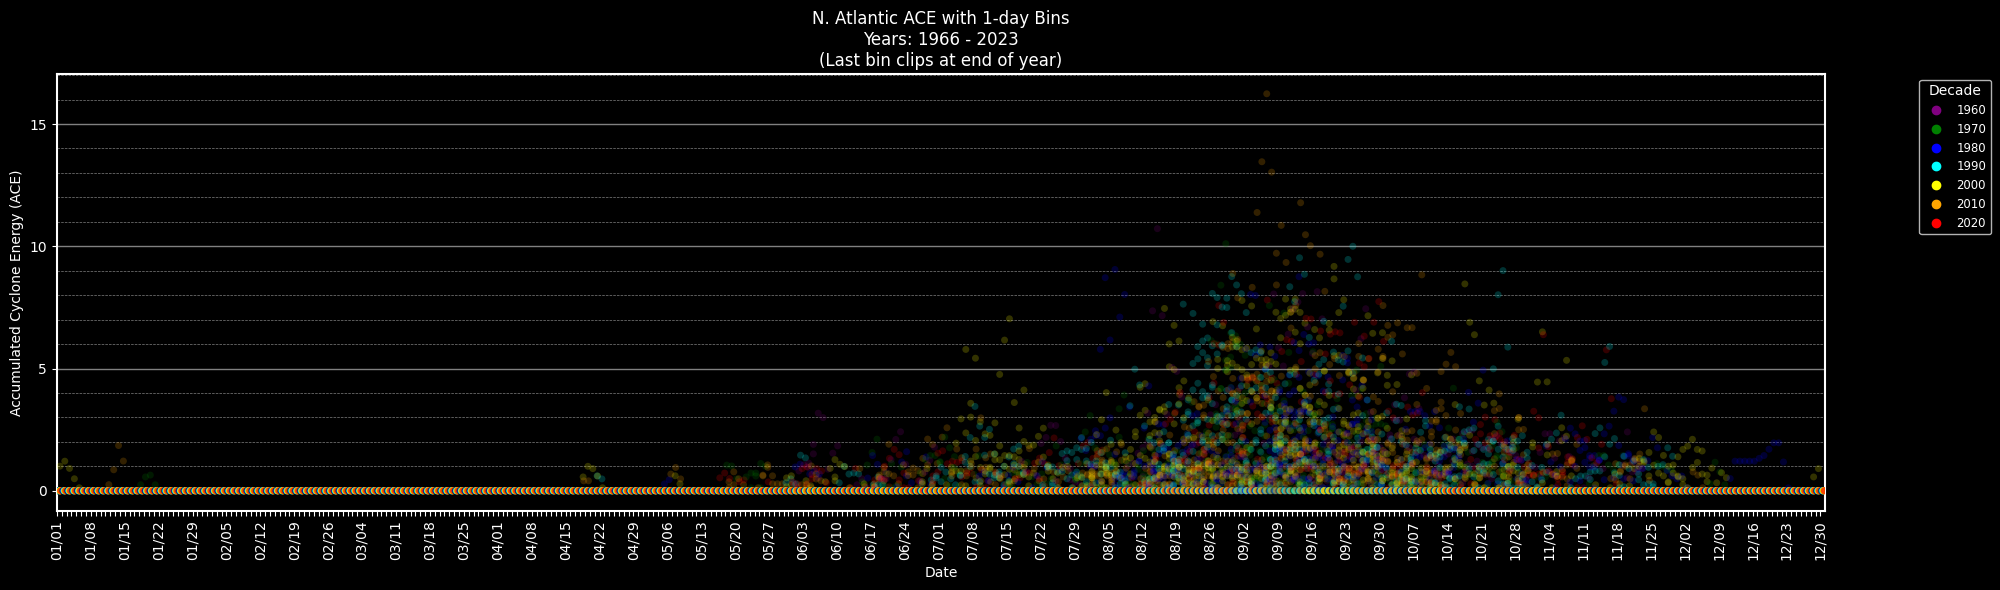

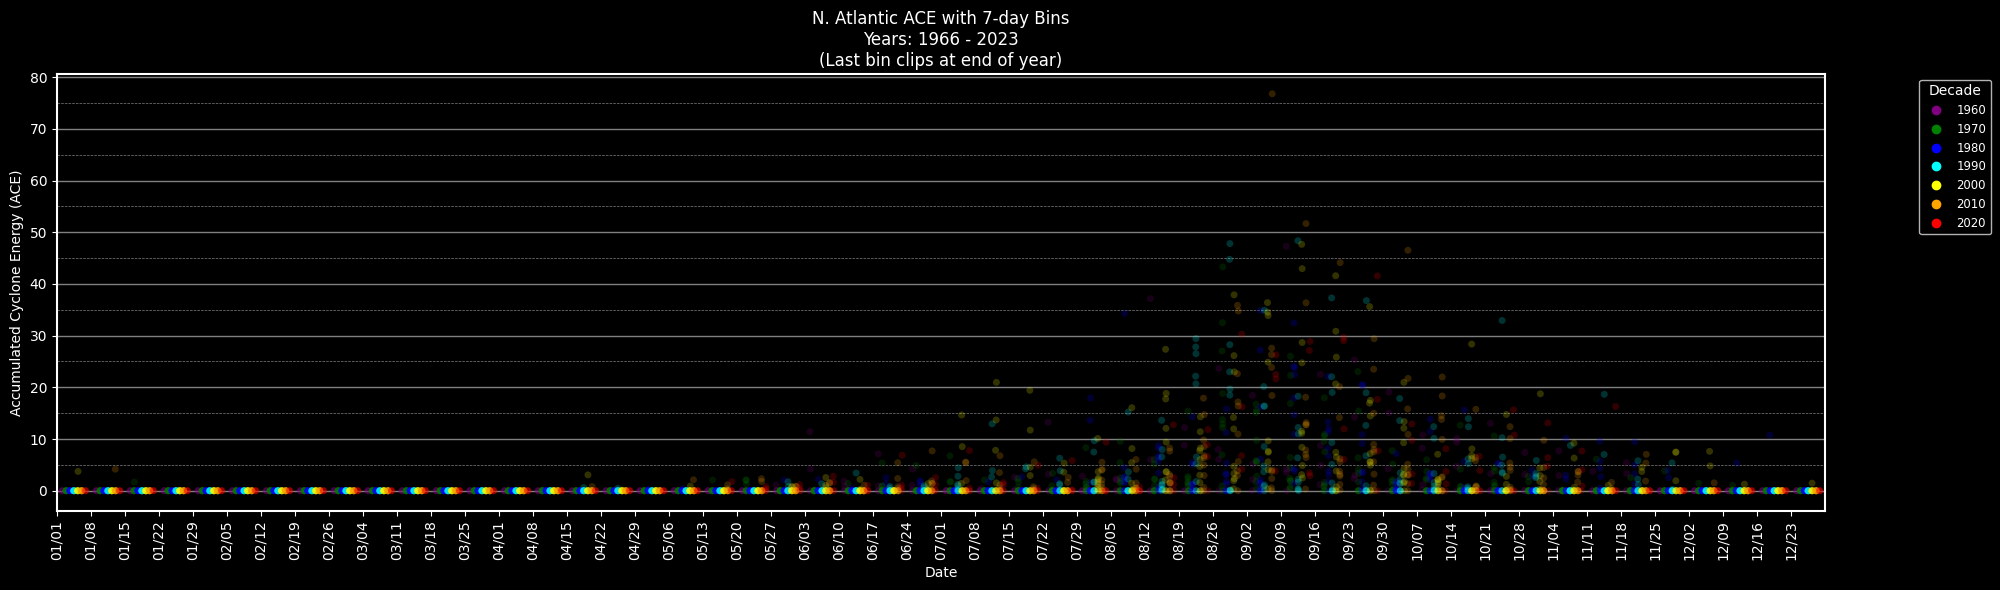

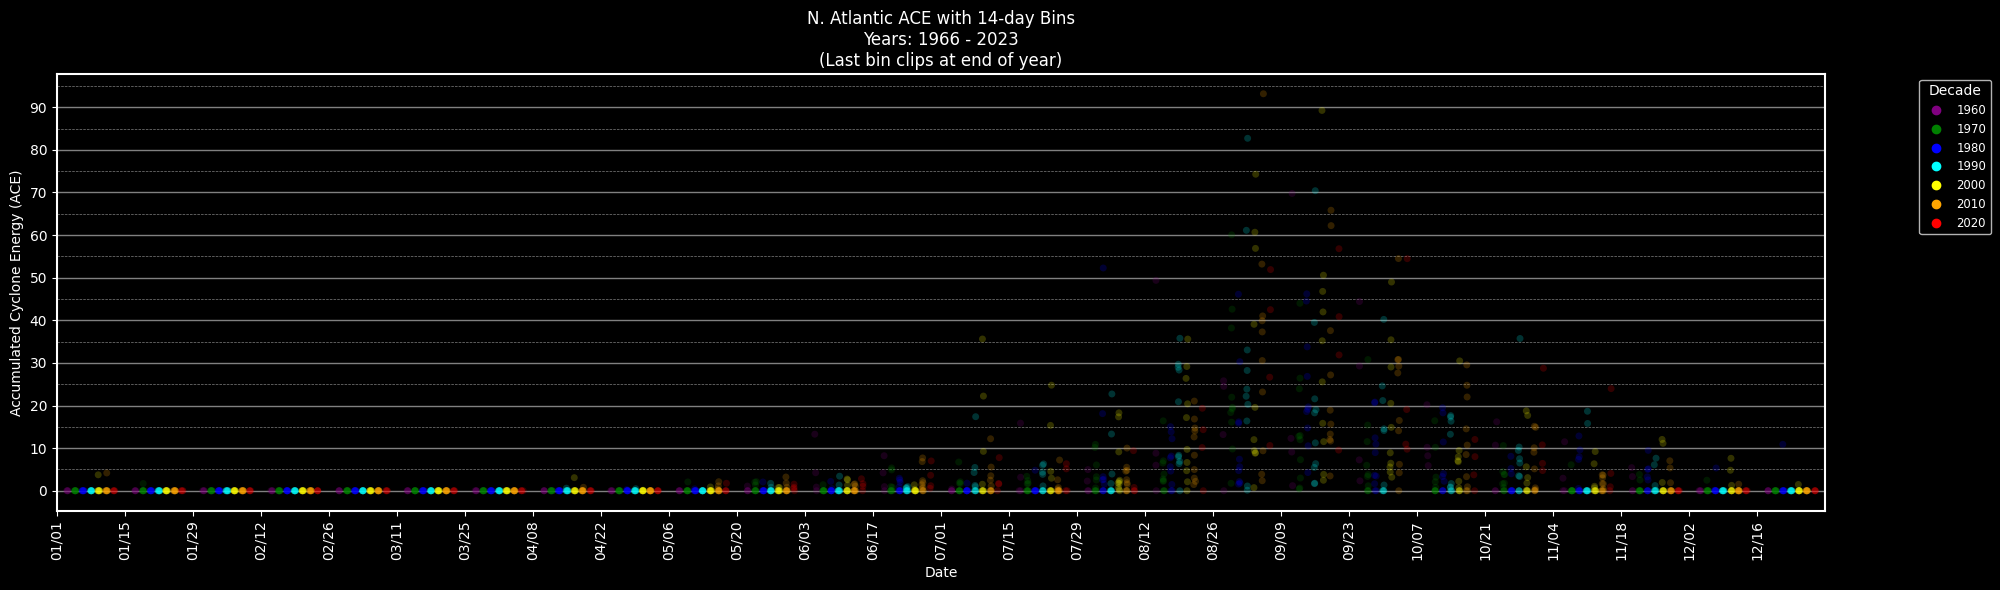

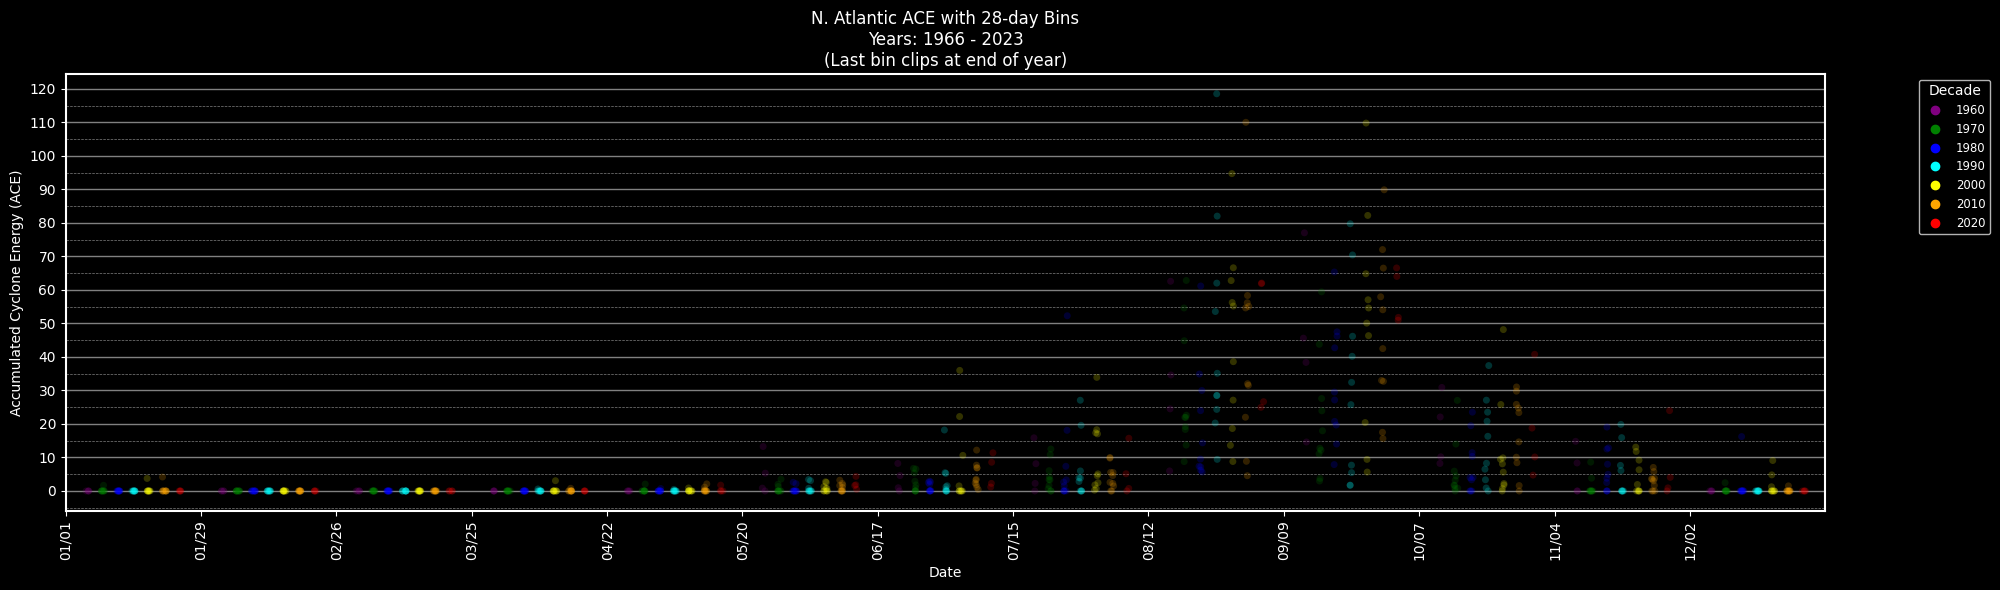

In [1109]:
# Plot ACE with date-converted bins
plot_binned_ace(df_binned_1day, bin_size=1, title='N. Atlantic ACE with 1-day Bins')
plot_binned_ace(df_binned_7day, bin_size=7, title='N. Atlantic ACE with 7-day Bins')
plot_binned_ace(df_binned_14day, bin_size=14, title='N. Atlantic ACE with 14-day Bins')
plot_binned_ace(df_binned_28day, bin_size=28, title='N. Atlantic ACE with 28-day Bins')

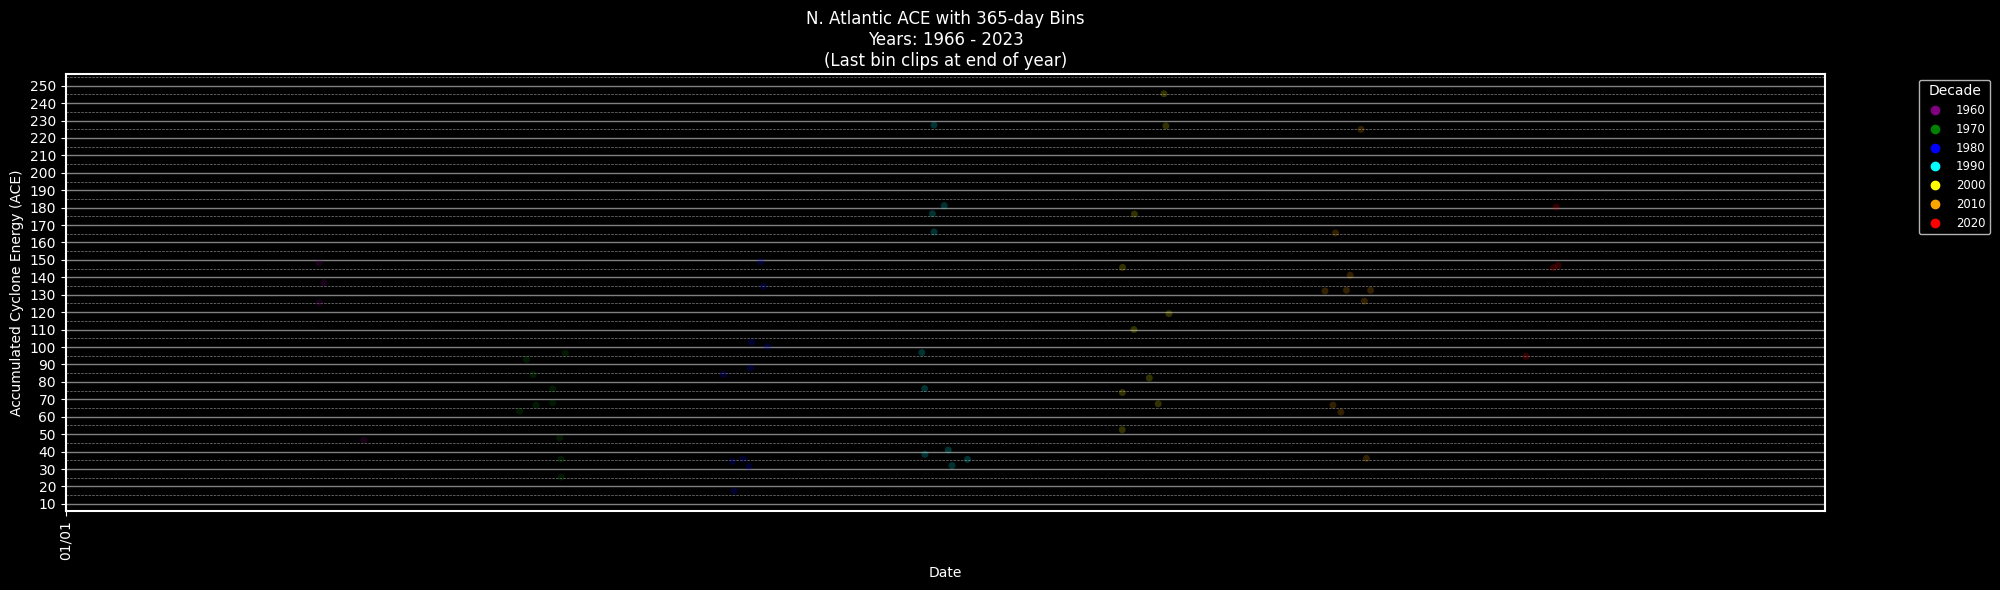

In [704]:
plot_binned_ace(df_binned_365day, bin_size=365, title='N. Atlantic ACE with 365-day Bins', opacity = 1.0)

In [661]:
import pandas as pd
from datetime import datetime

def calculate_days_to_reach_target_ace(df, ace_time, real_time_ACE, target_ace):
    # Calculate increase_target_ace
    increase_target_ace = target_ace - real_time_ACE
    
    # Convert ace_time to day number
    current_date = pd.to_datetime(ace_time)
    current_day_num = current_date.dayofyear
    
    results = []

    # Iterate through each year in the DataFrame
    for year, group in df.groupby('YEAR'):
        # Create a new DataFrame for the year's data
        year_data = group.set_index('DAY_NUM')['ACE_FOR_DAY_NUM']

        # Initialize an empty list for days taken for this year
        days_to_reach_target = []

        # Iterate through the remaining day numbers for this year
        for day_num in range(current_day_num, 366):  # Loop until the end of the year
            accumulated_ace = 0
            days_count = 0
            
            # Check each day's ACE until we reach the target
            for future_day in range(day_num, 366):  # Loop for each day starting from the current day
                accumulated_ace += year_data.get(future_day, 0)  # Get ACE for the day
                days_count += 1
                
                # Check if accumulated ACE meets or exceeds the target
                if accumulated_ace >= increase_target_ace:
                    days_to_reach_target.append(days_count)
                    break
            else:
                # If we finish the loop without breaking, we didn't reach the target
                days_to_reach_target.append(99)  # None or some marker if the target wasn't reached


        # Determine the decade for the current year
        decade = (year // 10) * 10

        results.append({'YEAR': year, 'DAYS_TO_REACH_TARGET': days_to_reach_target, 'DECADE': decade})

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Example Usage
# df should contain 'YEAR', 'DAY_NUM', and 'ACE_FOR_DAY_NUM'
# ace_time is a datetime string, e.g., '2024-10-23'
# real_time_ACE is a numeric value for the ACE accumulated so far this year
target_ace = 159.6  # Example target ACE

# Assuming df is your DataFrame with relevant ACE data
days_to_target_df = calculate_days_to_reach_target_ace(df_ace_by_day, ace_time, real_time_ACE, target_ace)

# Display the resulting DataFrame
print(days_to_target_df)

increase_target_ace = target_ace - real_time_ACE

    YEAR                               DAYS_TO_REACH_TARGET  DECADE
0   1966  [26, 25, 24, 23, 22, 21, 20, 99, 99, 99, 99, 9...    1960
1   1967  [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9...    1960
2   1968  [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9...    1960
3   1969  [25, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9...    1960
4   1970  [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9...    1970
..   ...                                                ...     ...
53  2019  [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9...    2010
54  2020  [11, 10, 9, 9, 9, 12, 12, 11, 10, 9, 8, 7, 6, ...    2020
55  2021  [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9...    2020
56  2022  [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9...    2020
57  2023  [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9...    2020

[58 rows x 3 columns]


In [692]:
# Calculate the number of years where it was possible to reach the target ACE
years_possible = days_to_target_df[days_to_target_df['DAYS_TO_REACH_TARGET'].apply(lambda x: any(day != 99 for day in x))]

# Count the number of such years
count_years_possible = years_possible['YEAR'].nunique()

print(f"Number of years where it was possible to reach the required ACE: {count_years_possible}")

Number of years where it was possible to reach the required ACE: 9


In [699]:
np.sum(np.array(list(season_ace.values())) > 159.6)

10

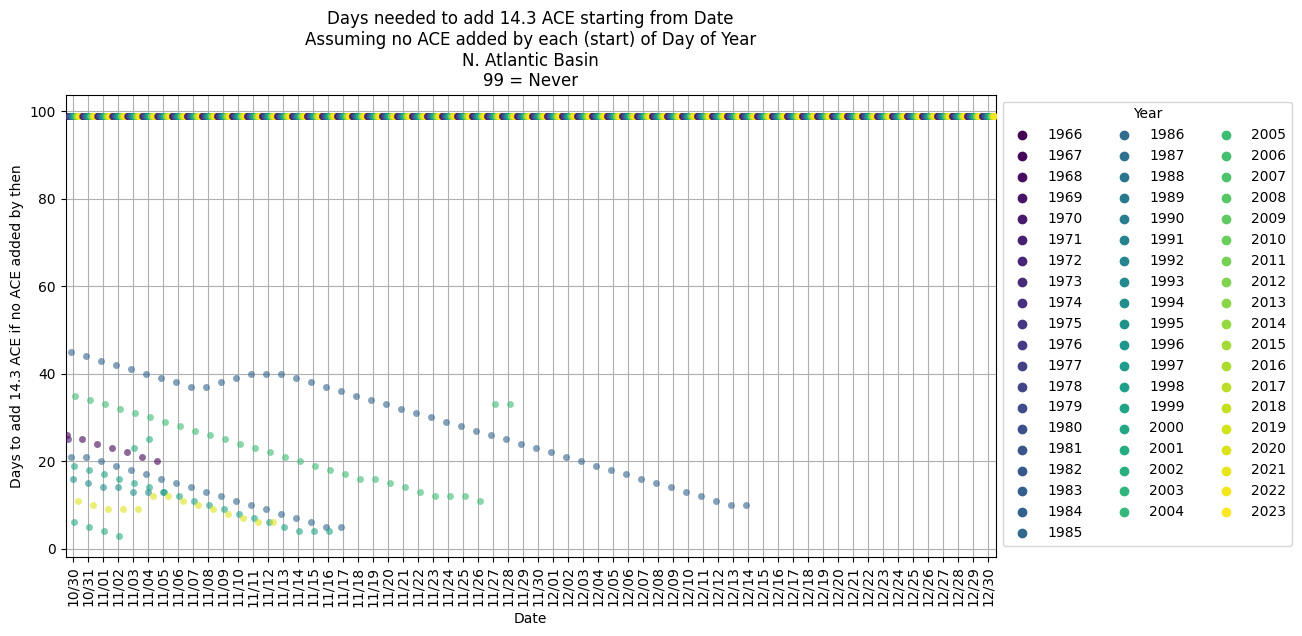

In [749]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming results_df has been prepared with 'YEAR', 'DAYS_TO_REACH_TARGET', and 'DECADE' columns

def plot_days_to_target_ace_by_decade(df_binned):
    # Assuming df is your DataFrame with columns 'DAY_NUM', 'DAYS_TO_TARGET', and 'DECADE'

    # Assuming df_binned is already created and contains the YEAR and DAYS_TO_REACH_TARGET columns

    # Explode the DAYS_TO_REACH_TARGET lists into separate rows
    df_exploded = df_binned.explode('DAYS_TO_REACH_TARGET')

    # Create a new DAY_NUMBER column based on the index of the exploded DataFrame
    # This represents the day number for each year, starting from 1 for January 1st
    df_exploded['DAY_NUMBER'] = df_exploded.groupby('YEAR').cumcount() + 1
    current_date = pd.to_datetime(ace_time)
    current_day_num = current_date.dayofyear

    df_exploded['DAY_NUMBER'] = df_exploded['DAY_NUMBER'] + current_day_num - 1
    
    # Adjust for leap years
    is_leap_year = df_exploded['YEAR'].apply(lambda x: (x % 4 == 0 and x % 100 != 0) or (x % 400 == 0))
    df_exploded.loc[is_leap_year, 'DAY_NUMBER'] = df_exploded.loc[is_leap_year, 'DAY_NUMBER'].clip(upper=366)

    df_exploded['DATE'] = df_exploded['DAY_NUMBER'].apply(day_number_to_date)
    
    # Ensure we don't exceed the maximum day count
    df_exploded['DAYS_TO_REACH_TARGET'] = df_exploded['DAYS_TO_REACH_TARGET'].clip(upper=366)
    
    # Plot using SeabornY
    plt.figure(figsize=(12, 6))
    sns.stripplot(data=df_exploded, x='DATE', y='DAYS_TO_REACH_TARGET', dodge = True, hue='YEAR', alpha=0.6, palette='viridis', legend='full')

    # Customizing the legend
    plt.legend(title='Year', ncol=3, loc='upper left', bbox_to_anchor=(1, 1))  # Change ncol to desired number of columns

    plt.title(f'Days needed to add {increase_target_ace:0.1f} ACE starting from Date\nAssuming no ACE added by each (start) of Day of Year\nN. Atlantic Basin\n99 = Never')
    plt.xlabel('Date')
    plt.ylabel(f'Days to add {increase_target_ace:0.1f} ACE if no ACE added by then')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

# Assuming days_to_target_df is the DataFrame returned from the calculation function
plot_days_to_target_ace_by_decade(days_to_target_df)


In [716]:
# Calculate the number of years where it was possible to reach the target ACE
years_possible = days_to_target_df[days_to_target_df['DAYS_TO_REACH_TARGET'].apply(lambda x: any(day != 99 for day in x))]

# Count the number of such years
count_years_possible = years_possible['YEAR'].nunique()

print(f"Number of years where it was possible to reach the required ACE: {count_years_possible}")

Number of years where it was possible to reach the required ACE: 9


In [1081]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Fetch the webpage
url = 'https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php'
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Locate the table in the page
table = soup.find('table', {'border': '1'})  # Adjust this based on the exact HTML structure

# Extract rows from the table
rows = table.find_all('tr')

# Initialize a list to store table data
data = []

# Loop over rows and extract cell values
for row in rows:
    cols = row.find_all('td')
    cols = [col.text.strip() for col in cols]
    if cols:
        data.append(cols)

# Create a DataFrame from the data
enso_oni_df = pd.DataFrame(data[1:], columns=data[0])  # First row as column headers

# Drop duplicate "Year" headers
enso_oni_df = df[df['Year'] != 'Year']

# Convert "Year" column to integers
enso_oni_df['Year'] = pd.to_numeric(enso_oni_df['Year'], errors='coerce').astype(int)

# Convert all other columns to floats, setting non-numeric values to np.nan
enso_oni_df.iloc[:, 1:] = enso_oni_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Display the DataFrame
print(enso_oni_df)


    Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
0   1950 -1.5 -1.3 -1.2 -1.2 -1.1 -0.9 -0.5 -0.4 -0.4 -0.4 -0.6 -0.8
1   1951 -0.8 -0.5 -0.2  0.2  0.4  0.6  0.7  0.9  1.0  1.2  1.0  0.8
2   1952  0.5  0.4  0.3  0.3  0.2  0.0 -0.1  0.0  0.2  0.1  0.0  0.1
3   1953  0.4  0.6  0.6  0.7  0.8  0.8  0.7  0.7  0.8  0.8  0.8  0.8
4   1954  0.8  0.5  0.0 -0.4 -0.5 -0.5 -0.6 -0.8 -0.9 -0.8 -0.7 -0.7
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
77  2020  0.5  0.5  0.4  0.2 -0.1 -0.3 -0.4 -0.6 -0.9 -1.2 -1.3 -1.2
78  2021 -1.0 -0.9 -0.8 -0.7 -0.5 -0.4 -0.4 -0.5 -0.7 -0.8 -1.0 -1.0
79  2022 -1.0 -0.9 -1.0 -1.1 -1.0 -0.9 -0.8 -0.9 -1.0 -1.0 -0.9 -0.8
80  2023 -0.7 -0.4 -0.1  0.2  0.5  0.8  1.1  1.3  1.6  1.8  1.9  2.0
81  2024  1.8  1.5  1.1  0.7  0.4  0.2  0.0 -0.1  NaN  NaN  NaN  NaN

[75 rows x 13 columns]


In [997]:
list(years_possible['YEAR'])

[1966, 1969, 1984, 1985, 1994, 1999, 2001, 2005, 2020]

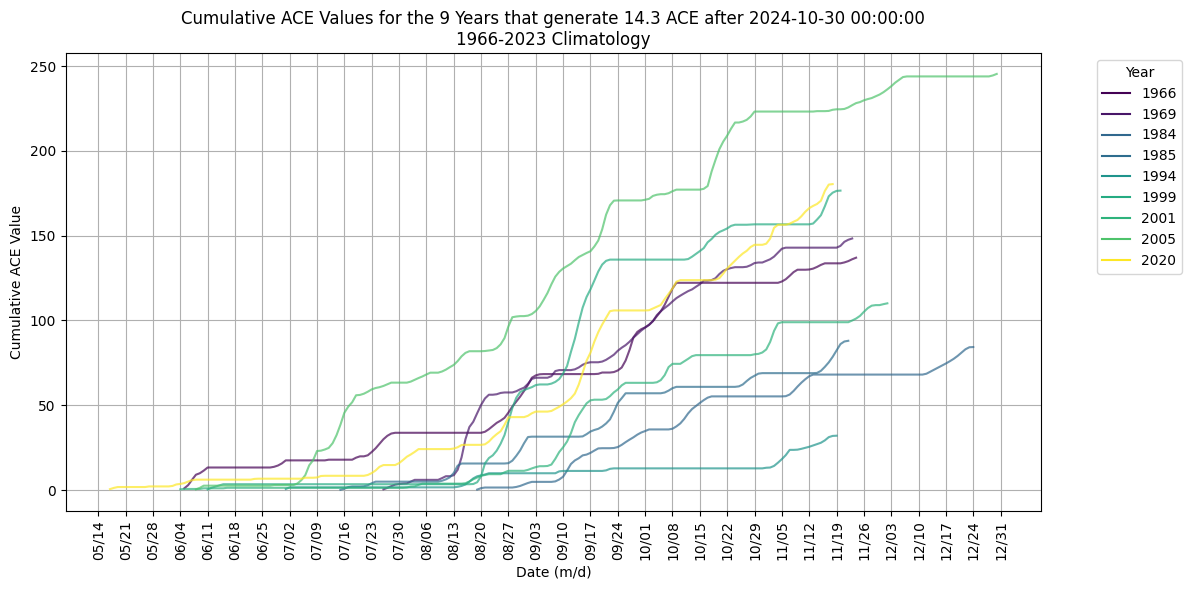

In [1024]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the list of years where it was possible to reach the required ACE
possible_years_list = list(years_possible['YEAR'])

# Step 2: Filter df_ace_by_day for those years and create a copy to avoid SettingWithCopyWarning
filtered_ace_data = df_ace_by_day[df_ace_by_day['YEAR'].isin(possible_years_list)].copy()

# Step 3: Calculate cumulative ACE values grouped by YEAR using .loc
filtered_ace_data.loc[:, 'CUMULATIVE_ACE'] = filtered_ace_data.groupby('YEAR')['ACE_FOR_DAY_NUM'].cumsum()


# Step 1: Get the list of years where it was possible to reach the required ACE
possible_years_list = list(years_possible['YEAR'])

# Step 2: Filter df_ace_by_day for those years and create a copy to avoid SettingWithCopyWarning
filtered_ace_data = df_ace_by_day[df_ace_by_day['YEAR'].isin(possible_years_list)].copy()

# Create a list to store the completed rows
completed_data = []

# Iterate through each year in the filtered DataFrame
for year in filtered_ace_data['YEAR'].unique():
    # Get data for the current year
    year_data = filtered_ace_data[filtered_ace_data['YEAR'] == year].sort_values('DAY_NUM')

    # Initialize variables to keep track of previous values
    previous_day_num = None
    previous_ace_value = None

    for index, row in year_data.iterrows():
        day_num = row['DAY_NUM']
        ace_value = row['ACE_FOR_DAY_NUM']

        # If this is the first row, just save the data
        if previous_day_num is None:
            previous_day_num = day_num
            previous_ace_value = ace_value
            completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
            continue
        
        # If there's a gap between DAY_NUMs, fill in the missing days
        while previous_day_num + 1 < day_num:
            previous_day_num += 1  # Increment the DAY_NUM
            completed_data.append({'YEAR': year, 'DAY_NUM': previous_day_num, 'ACE_FOR_DAY_NUM': 0.0})
        
        # Add the current row to the completed data
        completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
        
        # Update previous values
        previous_day_num = day_num
        previous_ace_value = ace_value

# Create a DataFrame from the completed data
completed_ace_data = pd.DataFrame(completed_data)

# If you want to include a DATE column, you can add it now
completed_ace_data['DATE'] = completed_ace_data['DAY_NUM'].apply(day_number_to_datetime)

# Optionally, calculate cumulative ACE values grouped by YEAR
completed_ace_data['CUMULATIVE_ACE'] = completed_ace_data.groupby('YEAR')['ACE_FOR_DAY_NUM'].cumsum()

filtered_ace_data = completed_ace_data

# Step 5: Reset index to ensure unique identification of rows
filtered_ace_data = filtered_ace_data.reset_index(drop=True)

# Step 6: Plot the cumulative ACE values
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_ace_data, x='DATE', y='CUMULATIVE_ACE', hue='YEAR', palette='viridis', alpha=0.7, legend='full')

# Set x-ticks at weekly intervals
weekly_ticks = pd.date_range(start=filtered_ace_data['DATE'].min() - timedelta(days=7), 
                              end=filtered_ace_data['DATE'].max() + timedelta(days=7), 
                              freq='W')

# Set the ticks on the x-axis
plt.xticks(ticks=weekly_ticks, 
           labels=weekly_ticks.strftime('%m/%d'),  # Format to show month/day
           rotation=90)  # Rotate labels for better visibility

# Adding titles and labels
plt.title(f'Cumulative ACE Values for the {count_years_possible} Years that generate {increase_target_ace:0.1f} ACE after {ace_time}\n{min_year}-{max_year} Climatology')
plt.xlabel('Date (m/d)')
plt.ylabel('Cumulative ACE Value')
plt.grid(True)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the legend placement
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [1096]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the list of years where it was possible to reach the required ACE
possible_years_list = list(years_possible['YEAR'])

# Step 2: Filter df_ace_by_day for those years and create a copy to avoid SettingWithCopyWarning
filtered_ace_data = df_ace_by_day[df_ace_by_day['YEAR'].isin(possible_years_list)].copy()

# Step 3: Calculate cumulative ACE values grouped by YEAR using .loc
filtered_ace_data.loc[:, 'CUMULATIVE_ACE'] = filtered_ace_data.groupby('YEAR')['ACE_FOR_DAY_NUM'].cumsum()


# Step 1: Get the list of years where it was possible to reach the required ACE
possible_years_list = list(years_possible['YEAR'])

# Step 2: Filter df_ace_by_day for those years and create a copy to avoid SettingWithCopyWarning
filtered_ace_data = df_ace_by_day[df_ace_by_day['YEAR'].isin(possible_years_list)].copy()

# Create a list to store the completed rows
completed_data = []

# Iterate through each year in the filtered DataFrame
for year in filtered_ace_data['YEAR'].unique():
    # Get data for the current year
    year_data = filtered_ace_data[filtered_ace_data['YEAR'] == year].sort_values('DAY_NUM')

    # Initialize variables to keep track of previous values
    previous_day_num = None
    previous_ace_value = None

    for index, row in year_data.iterrows():
        day_num = row['DAY_NUM']
        ace_value = row['ACE_FOR_DAY_NUM']

        # If this is the first row, just save the data
        if previous_day_num is None:
            previous_day_num = day_num
            previous_ace_value = ace_value
            completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
            continue
        
        # If there's a gap between DAY_NUMs, fill in the missing days
        while previous_day_num + 1 < day_num:
            previous_day_num += 1  # Increment the DAY_NUM
            completed_data.append({'YEAR': year, 'DAY_NUM': previous_day_num, 'ACE_FOR_DAY_NUM': 0.0})
        
        # Add the current row to the completed data
        completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
        
        # Update previous values
        previous_day_num = day_num
        previous_ace_value = ace_value

# Create a DataFrame from the completed data
completed_ace_data = pd.DataFrame(completed_data)

# If you want to include a DATE column, you can add it now
completed_ace_data['DATE'] = completed_ace_data['DAY_NUM'].apply(day_number_to_datetime)

# Optionally, calculate cumulative ACE values grouped by YEAR
completed_ace_data['CUMULATIVE_ACE'] = completed_ace_data.groupby('YEAR')['ACE_FOR_DAY_NUM'].cumsum()

filtered_ace_data = completed_ace_data

# Step 5: Reset index to ensure unique identification of rows
filtered_ace_data = filtered_ace_data.reset_index(drop=True)


# Filter the ENSO data for matching years
filtered_enso_oni_df = enso_oni_df[enso_oni_df['Year'].isin(possible_years_list)]



# Generate pseudo-dates for the ENSO seasons using a fixed year (e.g., 2000)
season_dates = pd.date_range(start="2000-01-01", periods=12, freq='MS')

# Reshape the ENSO data to match the seasons
enso_melted = pd.melt(filtered_enso_oni_df, id_vars=['Year'], value_vars=['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ'], 
                      var_name='Season', value_name='ONI')

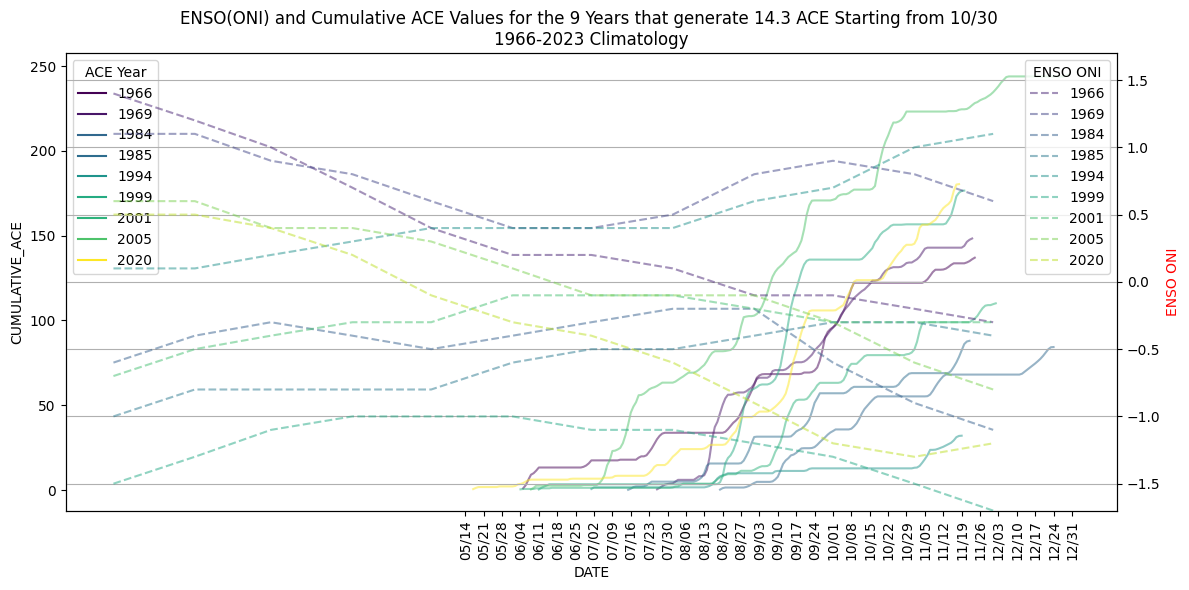

In [1104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the list of years where it was possible to reach the required ACE
possible_years_list = list(years_possible['YEAR'])

# Step 2: Filter df_ace_by_day for those years and create a copy to avoid SettingWithCopyWarning
filtered_ace_data = df_ace_by_day[df_ace_by_day['YEAR'].isin(possible_years_list)].copy()

# Step 3: Calculate cumulative ACE values grouped by YEAR using .loc
filtered_ace_data.loc[:, 'CUMULATIVE_ACE'] = filtered_ace_data.groupby('YEAR')['ACE_FOR_DAY_NUM'].cumsum()


# Step 1: Get the list of years where it was possible to reach the required ACE
possible_years_list = list(years_possible['YEAR'])

# Step 2: Filter df_ace_by_day for those years and create a copy to avoid SettingWithCopyWarning
filtered_ace_data = df_ace_by_day[df_ace_by_day['YEAR'].isin(possible_years_list)].copy()

# Create a list to store the completed rows
completed_data = []

# Iterate through each year in the filtered DataFrame
for year in filtered_ace_data['YEAR'].unique():
    # Get data for the current year
    year_data = filtered_ace_data[filtered_ace_data['YEAR'] == year].sort_values('DAY_NUM')

    # Initialize variables to keep track of previous values
    previous_day_num = None
    previous_ace_value = None

    for index, row in year_data.iterrows():
        day_num = row['DAY_NUM']
        ace_value = row['ACE_FOR_DAY_NUM']

        # If this is the first row, just save the data
        if previous_day_num is None:
            previous_day_num = day_num
            previous_ace_value = ace_value
            completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
            continue
        
        # If there's a gap between DAY_NUMs, fill in the missing days
        while previous_day_num + 1 < day_num:
            previous_day_num += 1  # Increment the DAY_NUM
            completed_data.append({'YEAR': year, 'DAY_NUM': previous_day_num, 'ACE_FOR_DAY_NUM': 0.0})
        
        # Add the current row to the completed data
        completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
        
        # Update previous values
        previous_day_num = day_num
        previous_ace_value = ace_value

# Create a DataFrame from the completed data
completed_ace_data = pd.DataFrame(completed_data)

# If you want to include a DATE column, you can add it now
completed_ace_data['DATE'] = completed_ace_data['DAY_NUM'].apply(day_number_to_datetime)

# Optionally, calculate cumulative ACE values grouped by YEAR
completed_ace_data['CUMULATIVE_ACE'] = completed_ace_data.groupby('YEAR')['ACE_FOR_DAY_NUM'].cumsum()

filtered_ace_data = completed_ace_data

# Step 5: Reset index to ensure unique identification of rows
filtered_ace_data = filtered_ace_data.reset_index(drop=True)


# Filter the ENSO data for matching years
filtered_enso_oni_df = enso_oni_df[enso_oni_df['Year'].isin(possible_years_list)]



# Generate pseudo-dates for the ENSO seasons using a fixed year (e.g., 2000)
season_dates = pd.date_range(start="2000-01-01", periods=12, freq='MS')

# Reshape the ENSO data to match the seasons
enso_melted = pd.melt(filtered_enso_oni_df, id_vars=['Year'], value_vars=['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ'], 
                      var_name='Season', value_name='ONI')

# Map the seasons to the pseudo-dates
season_mapping = dict(zip(['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ'], season_dates))
enso_melted['PseudoDate'] = enso_melted['Season'].map(season_mapping)

# Now filter the ENSO data for matching years in possible_years_list
# Filter and sort the DataFrame by Year
filtered_enso_melted = enso_melted[enso_melted['Year'].isin(possible_years_list)].sort_values(by='Year')





import seaborn as sns
import matplotlib.pyplot as plt

# Create a colormap for the ACE plot
palette = sns.color_palette('viridis', n_colors=len(filtered_ace_data['YEAR'].unique()))
year_to_color = dict(zip(filtered_ace_data['YEAR'].unique(), palette))

# Step 6: Plot the cumulative ACE values
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=filtered_ace_data, x='DATE', y='CUMULATIVE_ACE', hue='YEAR', palette='viridis', alpha=0.5, legend='full')

# Set x-ticks at weekly intervals
weekly_ticks = pd.date_range(start=filtered_ace_data['DATE'].min() - timedelta(days=7), 
                              end=filtered_ace_data['DATE'].max() + timedelta(days=7), 
                              freq='W')

# Set the ticks on the x-axis
plt.xticks(ticks=weekly_ticks, 
           labels=weekly_ticks.strftime('%m/%d'),  # Format to show month/day
           rotation=90)  # Rotate labels for better visibility

# Create a second y-axis for ENSO ONI values
ax2 = ax1.twinx()

# Plot ENSO ONI values on the second y-axis with colors matching ACE plot
for year in filtered_enso_melted['Year'].unique():
    subset = filtered_enso_melted[filtered_enso_melted['Year'] == year]
    sns.lineplot(data=subset, x='PseudoDate', y='ONI', color=year_to_color[year], label=year, ax=ax2, linestyle='--', alpha=0.5)

ax2.set_ylabel('ENSO ONI', color='red')
ax2.set_ylim([-max(abs(filtered_enso_melted['ONI'])), max(abs(filtered_enso_melted['ONI']))])

# Adding titles and labels
plt.title(f'ENSO(ONI) and Cumulative ACE Values for the {count_years_possible} Years that generate {increase_target_ace:0.1f} ACE Starting from {ace_time.strftime("%m/%d")} \n{min_year}-{max_year} Climatology')


plt.grid(True)
ax1.legend(title='ACE Year', loc='upper left')
ax2.legend(title='ENSO ONI', loc='upper right')
plt.tight_layout()

plt.show()


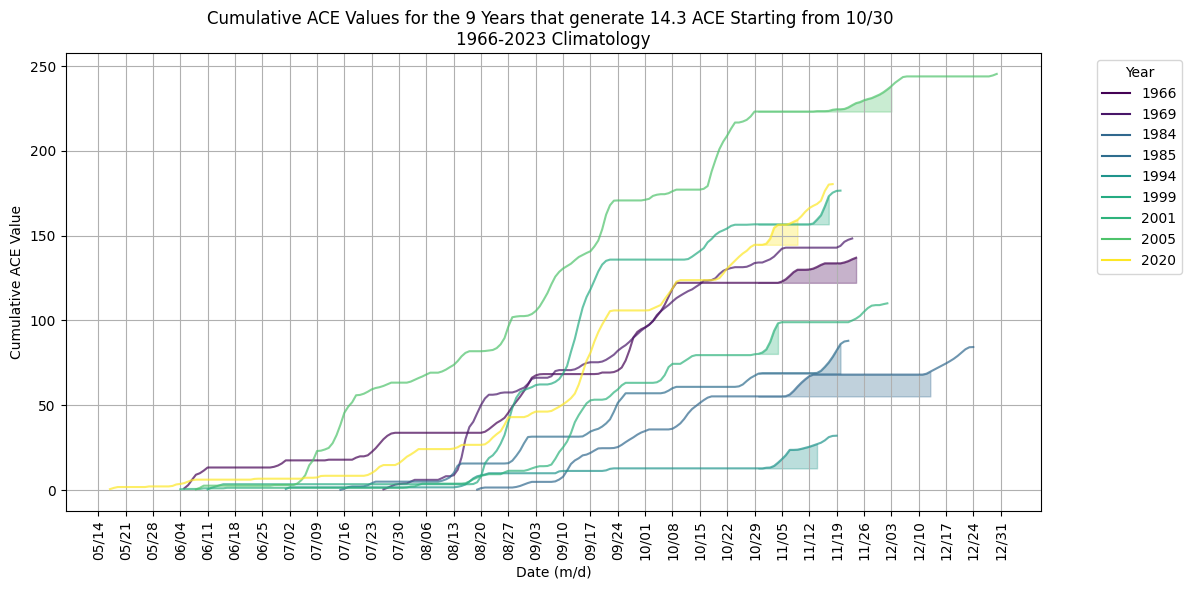

In [1075]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Step 1: Get the list of years where it was possible to reach the required ACE
possible_years_list = list(years_possible['YEAR'])

# Step 2: Filter df_ace_by_day for those years and create a copy to avoid SettingWithCopyWarning
filtered_ace_data = df_ace_by_day[df_ace_by_day['YEAR'].isin(possible_years_list)].copy()

# Create a list to store the completed rows
completed_data = []

# Iterate through each year in the filtered DataFrame
for year in filtered_ace_data['YEAR'].unique():
    # Get data for the current year
    year_data = filtered_ace_data[filtered_ace_data['YEAR'] == year].sort_values('DAY_NUM')

    # Initialize variables to keep track of previous values
    previous_day_num = None
    previous_ace_value = None

    for index, row in year_data.iterrows():
        day_num = row['DAY_NUM']
        ace_value = row['ACE_FOR_DAY_NUM']

        # If this is the first row, just save the data
        if previous_day_num is None:
            previous_day_num = day_num
            previous_ace_value = ace_value
            completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
            continue
        
        # If there's a gap between DAY_NUMs, fill in the missing days
        while previous_day_num + 1 < day_num:
            previous_day_num += 1  # Increment the DAY_NUM
            completed_data.append({'YEAR': year, 'DAY_NUM': previous_day_num, 'ACE_FOR_DAY_NUM': 0.0})
        
        # Add the current row to the completed data
        completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
        
        # Update previous values
        previous_day_num = day_num
        previous_ace_value = ace_value

# Create a DataFrame from the completed data
completed_ace_data = pd.DataFrame(completed_data)

# If you want to include a DATE column, you can add it now
completed_ace_data['DATE'] = completed_ace_data['DAY_NUM'].apply(day_number_to_datetime)

# Optionally, calculate cumulative ACE values grouped by YEAR
completed_ace_data['CUMULATIVE_ACE'] = completed_ace_data.groupby('YEAR')['ACE_FOR_DAY_NUM'].cumsum()


# NOW PLOT THE POSSIBLES


# Step 1: Plot the cumulative ACE values
plt.figure(figsize=(12, 6))
sns.lineplot(data=completed_ace_data, x='DATE', y='CUMULATIVE_ACE', hue='YEAR', palette='viridis', alpha=0.7, legend='full')

# Step 2: Set x-ticks at weekly intervals
weekly_ticks = pd.date_range(start=completed_ace_data['DATE'].min() - timedelta(days=7), 
                              end=completed_ace_data['DATE'].max() + timedelta(days=7), 
                              freq='W')

# Set the ticks on the x-axis with month/day format
plt.xticks(ticks=weekly_ticks, 
           labels=weekly_ticks.strftime('%m/%d'), 
           rotation=90)

# Fill area below the curve starting from ace_time
for year in completed_ace_data['YEAR'].unique():
    year_data = completed_ace_data[completed_ace_data['YEAR'] == year]
    ace_time_2000 = ace_time
    ace_time_2000_ts = pd.Timestamp(ace_time_2000.replace(year=2000))
    
    # Check if the ace_time exists in year_data
    if ace_time_2000_ts in year_data['DATE'].values:
        # Get the index of ace_time to plot the fill area from this date onwards
        start_index = year_data[(year_data['YEAR'] == year)].index[0]
        ace_time_index_orig = year_data[(year_data['YEAR'] == year) & (year_data['DATE'] == ace_time_2000_ts)].index[0]
        ace_time_index = ace_time_index_orig - start_index

        # Get the starting CUMULATIVE_ACE value for the year
        starting_cumulative_ace = year_data['CUMULATIVE_ACE'].iloc[ace_time_index]
        
        # Calculate the target cumulative ACE value
        target_value = starting_cumulative_ace + increase_target_ace

        # Find the index where CUMULATIVE_ACE first meets or exceeds the target value
        end_index = year_data[year_data['CUMULATIVE_ACE'] >= target_value].index
        
        if not end_index.empty:
            end_index = end_index[0] - start_index  # Adjust to match the year_data indexing
            # Fill area from ace_time onwards, starting at the cumulative ACE value
            plt.fill_between(year_data['DATE'].iloc[ace_time_index:end_index + 1],  # Adjust the slice to include end_index
                             starting_cumulative_ace,  # Use starting CUMULATIVE_ACE as the lower bound
                             year_data['CUMULATIVE_ACE'].iloc[ace_time_index:end_index + 1], 
                             color=plt.cm.viridis((year - completed_ace_data['YEAR'].min()) / (completed_ace_data['YEAR'].max() - completed_ace_data['YEAR'].min())), 
                             alpha=0.3)

# Step 4: Adding titles and labels
plt.title(f'Cumulative ACE Values for the {count_years_possible} Years that generate {increase_target_ace:0.1f} ACE Starting from {ace_time.strftime("%m/%d")} \n{min_year}-{max_year} Climatology')
plt.xlabel('Date (m/d)')
plt.ylabel('Cumulative ACE Value')
plt.grid(True)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the legend placement
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

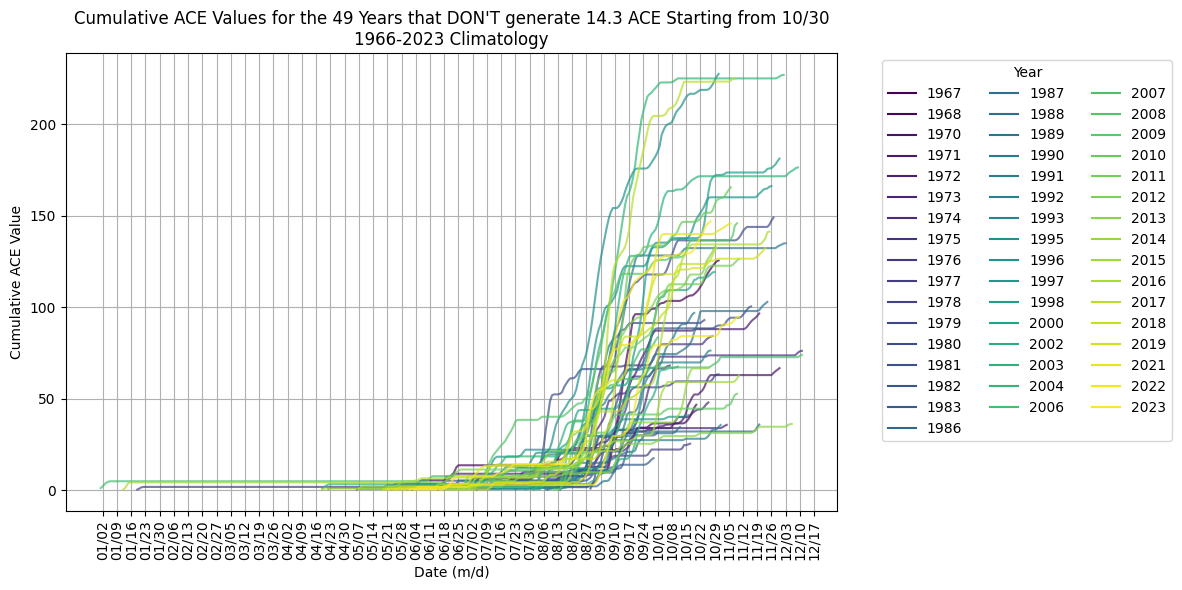

In [1064]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Step 1: Get the list of years where it was possible to reach the required ACE
impossible_years_list = list(set(range(min_year, max_year+1, 1)) - set(list(years_possible['YEAR'])))

count_years_impossible = len(impossible_years_list)

# Step 2: Filter df_ace_by_day for those years and create a copy to avoid SettingWithCopyWarning
filtered_ace_data = df_ace_by_day[df_ace_by_day['YEAR'].isin(impossible_years_list)].copy()

# Create a list to store the completed rows
completed_data = []

# Iterate through each year in the filtered DataFrame
for year in filtered_ace_data['YEAR'].unique():
    # Get data for the current year
    year_data = filtered_ace_data[filtered_ace_data['YEAR'] == year].sort_values('DAY_NUM')

    # Initialize variables to keep track of previous values
    previous_day_num = None
    previous_ace_value = None

    for index, row in year_data.iterrows():
        day_num = row['DAY_NUM']
        ace_value = row['ACE_FOR_DAY_NUM']

        # If this is the first row, just save the data
        if previous_day_num is None:
            previous_day_num = day_num
            previous_ace_value = ace_value
            completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
            continue
        
        # If there's a gap between DAY_NUMs, fill in the missing days
        while previous_day_num + 1 < day_num:
            previous_day_num += 1  # Increment the DAY_NUM
            completed_data.append({'YEAR': year, 'DAY_NUM': previous_day_num, 'ACE_FOR_DAY_NUM': 0.0})
        
        # Add the current row to the completed data
        completed_data.append({'YEAR': year, 'DAY_NUM': day_num, 'ACE_FOR_DAY_NUM': ace_value})
        
        # Update previous values
        previous_day_num = day_num
        previous_ace_value = ace_value

# Create a DataFrame from the completed data
completed_ace_data = pd.DataFrame(completed_data)

# If you want to include a DATE column, you can add it now
completed_ace_data['DATE'] = completed_ace_data['DAY_NUM'].apply(day_number_to_datetime)

# Optionally, calculate cumulative ACE values grouped by YEAR
completed_ace_data['CUMULATIVE_ACE'] = completed_ace_data.groupby('YEAR')['ACE_FOR_DAY_NUM'].cumsum()


# Step 1: Plot the cumulative ACE values
plt.figure(figsize=(12, 6))
sns.lineplot(data=completed_ace_data, x='DATE', y='CUMULATIVE_ACE', hue='YEAR', palette='viridis', alpha=0.7, legend='full')

# Step 2: Set x-ticks at weekly intervals
weekly_ticks = pd.date_range(start=completed_ace_data['DATE'].min() - timedelta(days=5), 
                              end=completed_ace_data['DATE'].max() + timedelta(days=7), 
                              freq='W')

# Set the ticks on the x-axis with month/day format
plt.xticks(ticks=weekly_ticks, 
           labels=weekly_ticks.strftime('%m/%d'), 
           rotation=90)

# Fill area below the curve starting from ace_time
for year in completed_ace_data['YEAR'].unique():
    year_data = completed_ace_data[completed_ace_data['YEAR'] == year]
    ace_time_2000 = ace_time
    ace_time_2000_ts = pd.Timestamp(ace_time_2000.replace(year=2000))
    
    # Check if the ace_time exists in year_data
    if ace_time_2000_ts in year_data['DATE'].values:
        # Get the index of ace_time to plot the fill area from this date onwards
        start_index = year_data[(year_data['YEAR'] == year)].index[0]
        ace_time_index_orig = year_data[(year_data['YEAR'] == year) & (year_data['DATE'] == ace_time_2000_ts)].index[0]
        ace_time_index = ace_time_index_orig - start_index

        # Get the starting CUMULATIVE_ACE value for the year
        starting_cumulative_ace = year_data['CUMULATIVE_ACE'].iloc[ace_time_index]
        
        # Calculate the target cumulative ACE value
        target_value = starting_cumulative_ace + increase_target_ace

        # Find the index where CUMULATIVE_ACE first meets or exceeds the target value
        end_index = year_data[year_data['CUMULATIVE_ACE'] >= target_value].index
        
        if not end_index.empty:
            end_index = end_index[0] - start_index  # Adjust to match the year_data indexing
            # Fill area from ace_time onwards, starting at the cumulative ACE value
            plt.fill_between(year_data['DATE'].iloc[ace_time_index:end_index + 1],  # Adjust the slice to include end_index
                             starting_cumulative_ace,  # Use starting CUMULATIVE_ACE as the lower bound
                             year_data['CUMULATIVE_ACE'].iloc[ace_time_index:end_index + 1], 
                             color=plt.cm.viridis((year - completed_ace_data['YEAR'].min()) / (completed_ace_data['YEAR'].max() - completed_ace_data['YEAR'].min())), 
                             alpha=0.3)

# Step 4: Adding titles and labels
plt.title(f'Cumulative ACE Values for the {count_years_impossible} Years that DON\'T generate {increase_target_ace:0.1f} ACE Starting from {ace_time.strftime("%m/%d")}\n{min_year}-{max_year} Climatology')
plt.xlabel('Date (m/d)')
plt.ylabel('Cumulative ACE Value')
plt.grid(True)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)  # Adjust the legend placement
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [961]:
completed_ace_data[completed_ace_data['YEAR'] == 2016]

,YEAR,DAY_NUM,ACE_FOR_DAY_NUM,DATE,CUMULATIVE_ACE
6065,2016,12.0,0.2500,2000-01-12,0.2500
6066,2016,13.0,0.8575,2000-01-13,1.1075
6067,2016,14.0,1.8500,2000-01-14,2.9575
6068,2016,15.0,1.2150,2000-01-15,4.1725
6069,2016,16.0,0.0000,2000-01-16,4.1725
...,...,...,...,...,...
6379,2016,326.0,0.4850,2000-11-21,134.7025
6380,2016,327.0,1.2725,2000-11-22,135.9750
6381,2016,328.0,1.5025,2000-11-23,137.4775
6382,2016,329.0,3.3525,2000-11-24,140.8300


Number of storms in AL basin with ACE > 35.1 (since 1966): 30
Years with storms in AL basin having ACE > 35.1 (since 1966): [1966, 1967, 1971, 1979, 1980, 1989, 1995, 1996, 1998, 1999, 2000, 2003, 2004, 2005, 2007, 2008, 2010, 2016, 2017, 2018, 2019, 2021, 2023]
% of years having storms in AL basin having ACE > 35.1 (since 1966): 51.7 %


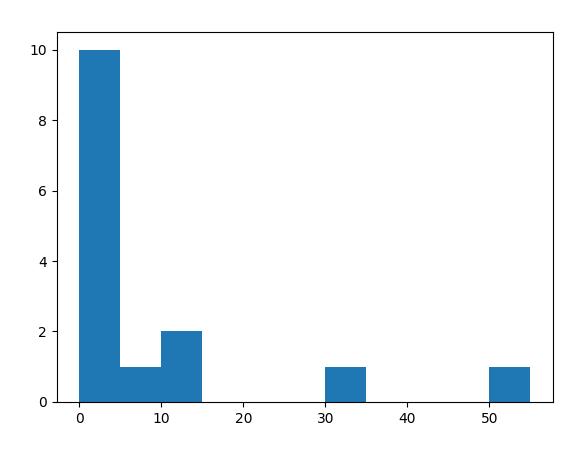

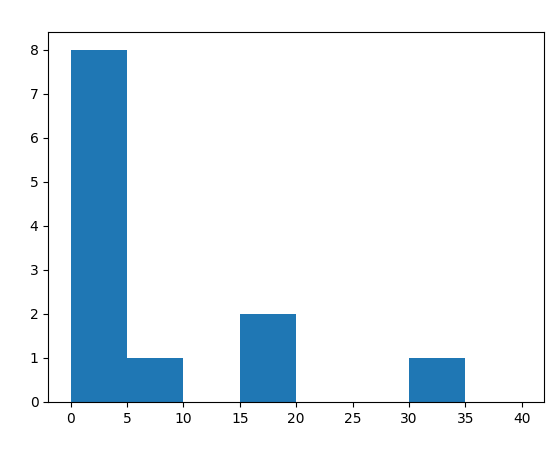

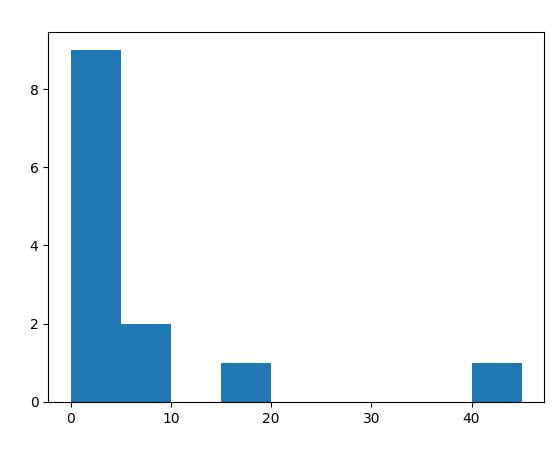

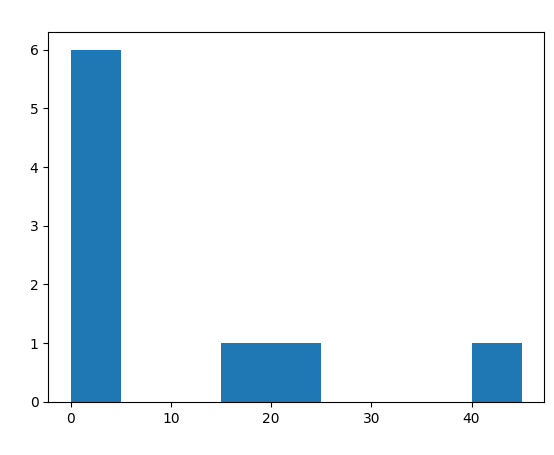

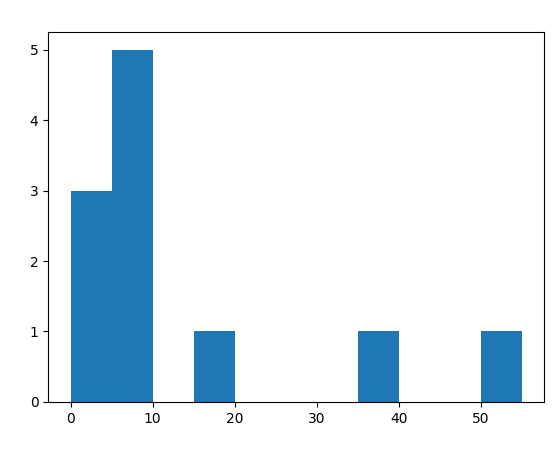

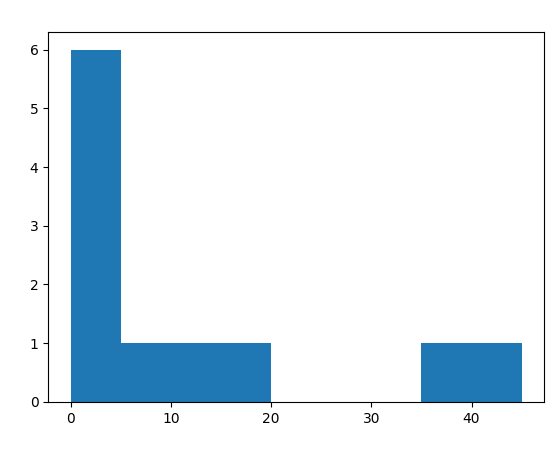

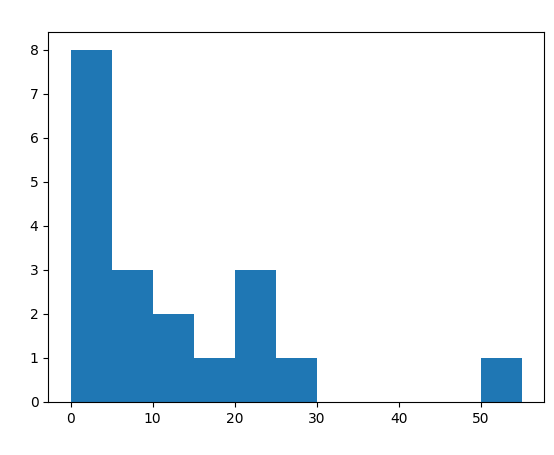

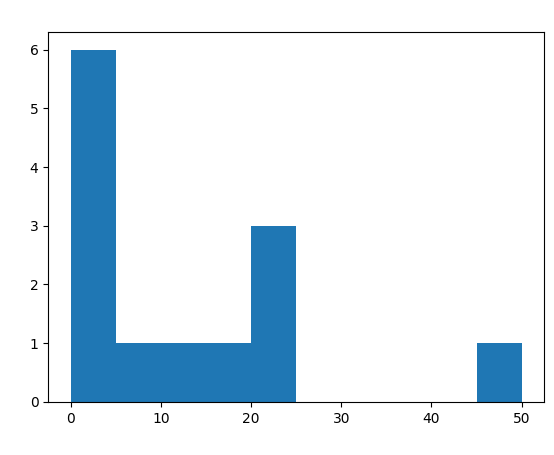

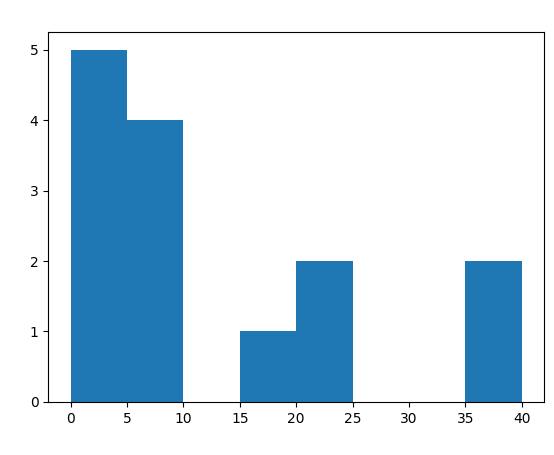

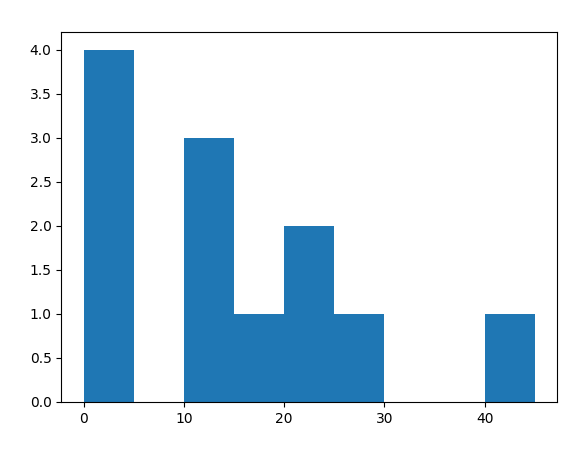

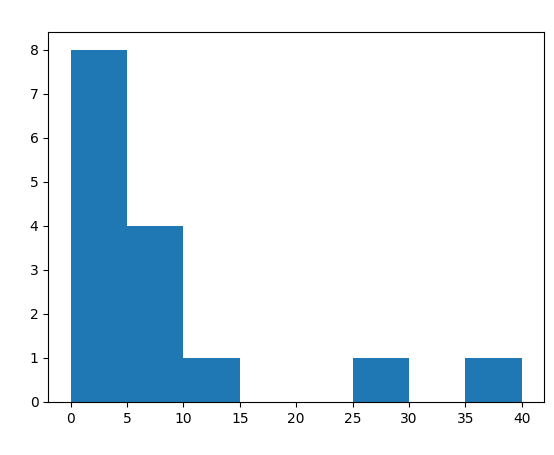

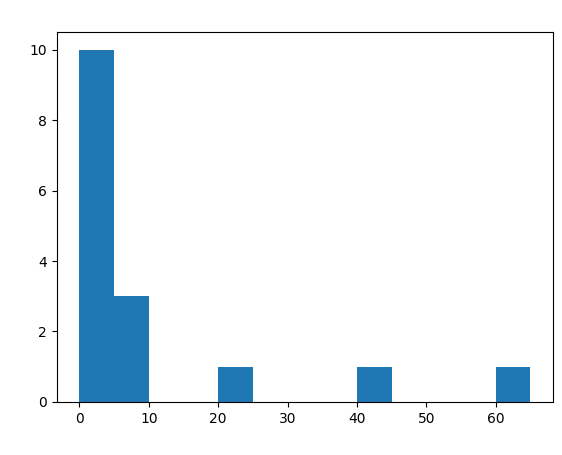

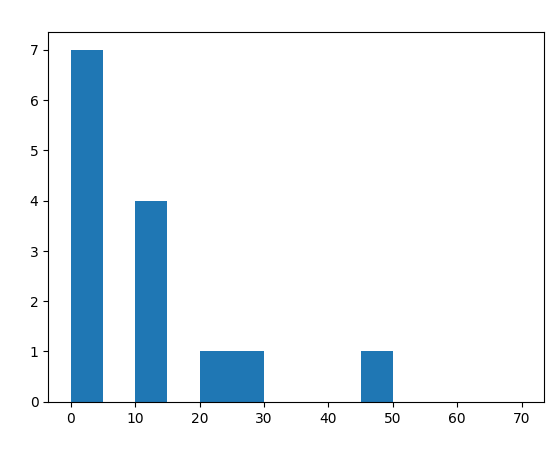

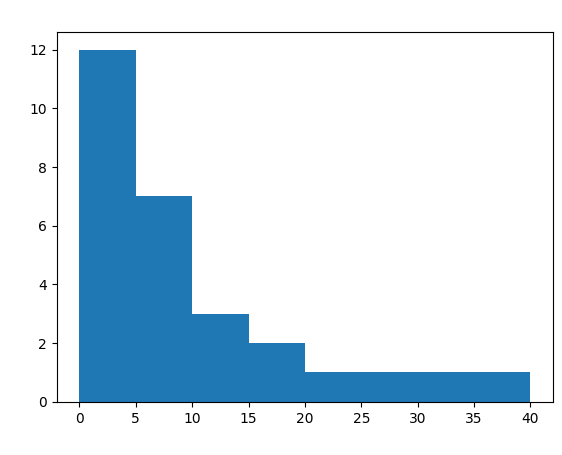

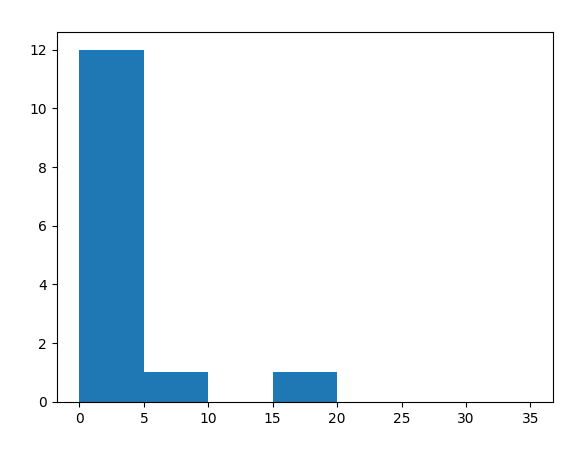

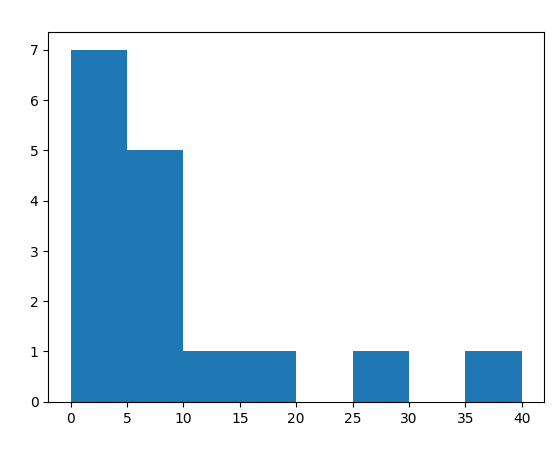

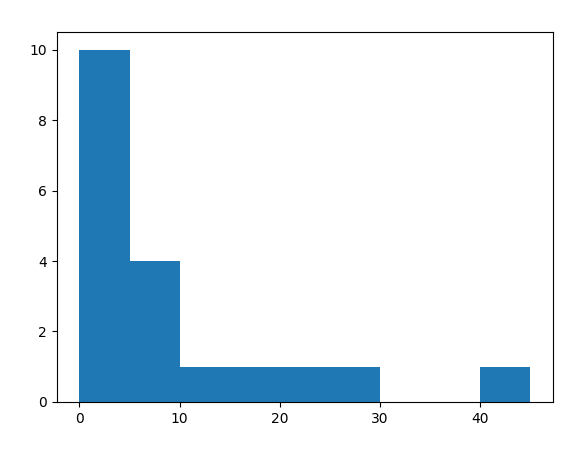

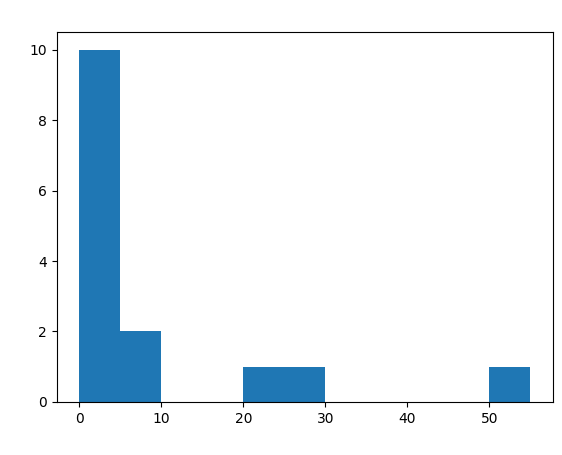

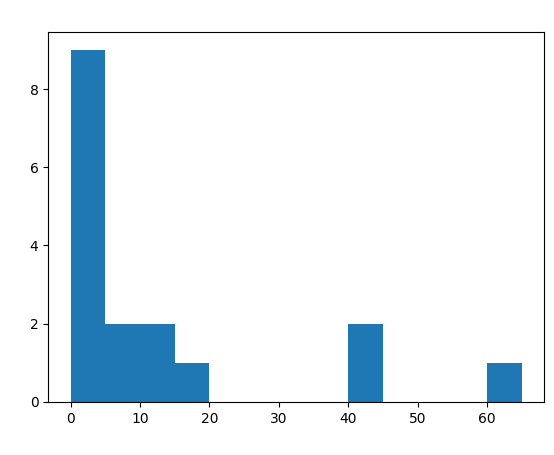

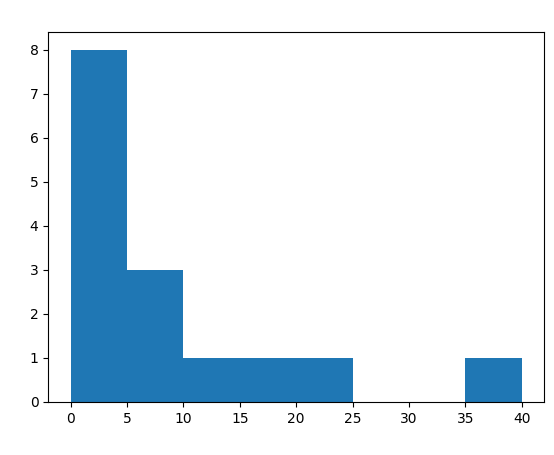

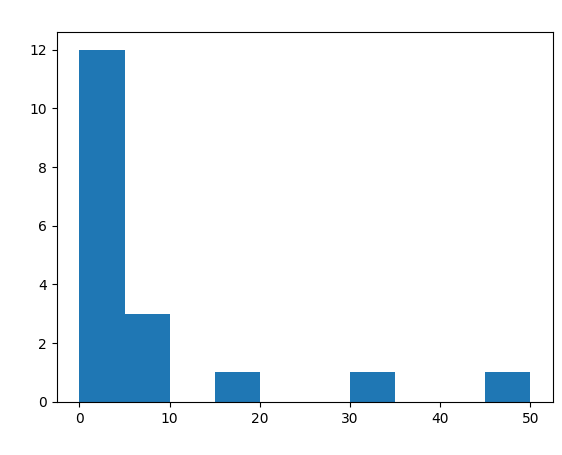

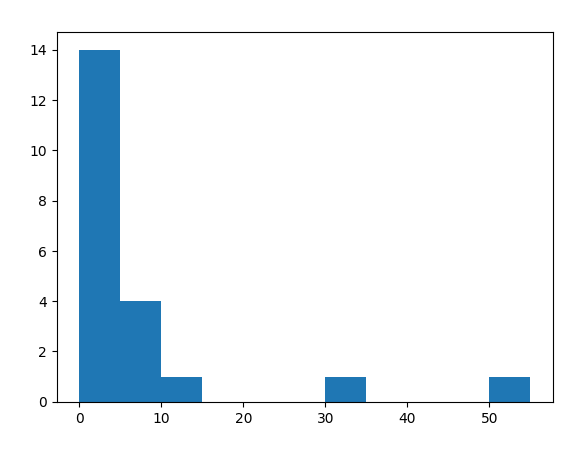

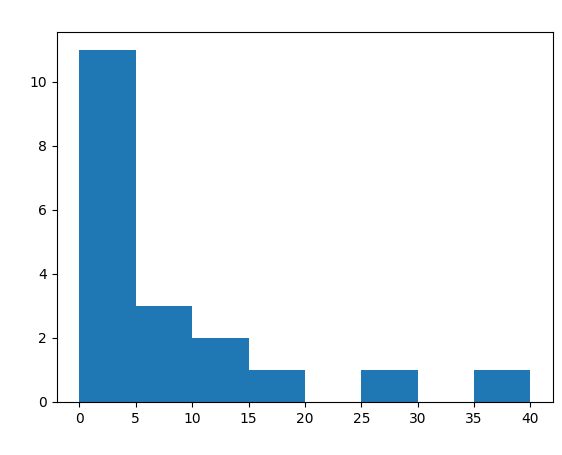

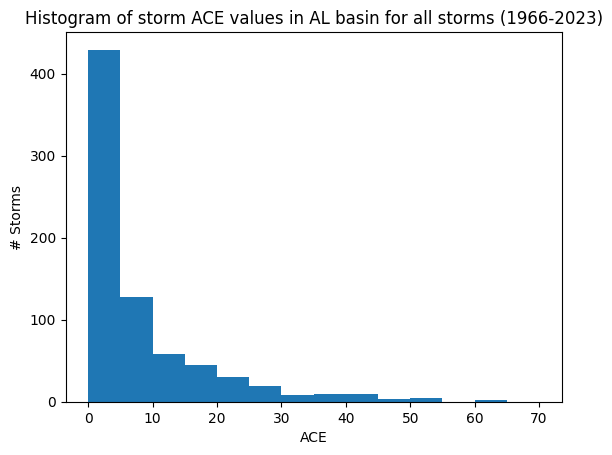

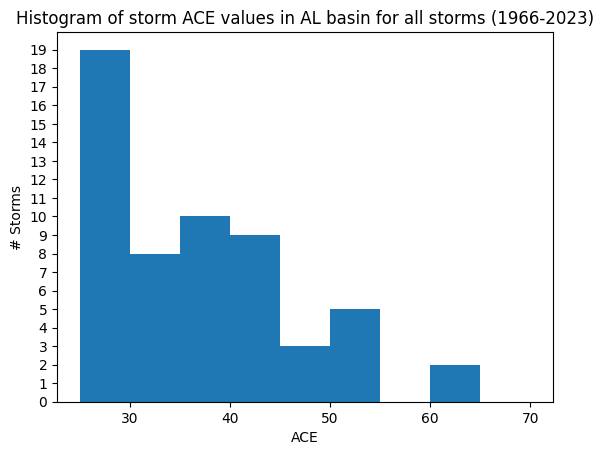

In [667]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
forecast_selected_storm_ace = 35.1

min_year = 1966  # Set the minimum year (configurable)

# Group ACE values by year
ace_by_year = {}
for atcf_id, ace in ace_by_atcf_id.items():
    year = int(atcf_id[-4:])  # Extract the year from the ATCF ID
    if year >= min_year:  # Only consider years greater than or equal to min_year
        if year not in ace_by_year:
            ace_by_year[year] = []
        ace_by_year[year].append(ace)

# Calculate the number of storms with higher ACE than forecast_selected_storm_ace
num_storms_higher_ace = 0
years_with_higher_ace = []
for year, ace_values in ace_by_year.items():
    if year >= min_year:  # Only consider years greater than or equal to min_year
        if any(ace > forecast_selected_storm_ace for ace in ace_values):
            num_storms_higher_ace += len([ace for ace in ace_values if ace > forecast_selected_storm_ace])
            years_with_higher_ace.append(year)

# Calculate the probability
num_years = len(ace_by_year)
probability = num_storms_higher_ace / num_years

# Print the results
print(f"Number of storms in AL basin with ACE > {forecast_selected_storm_ace} (since {min_year}): {num_storms_higher_ace}")
print(f"Years with storms in AL basin having ACE > {forecast_selected_storm_ace} (since {min_year}): {years_with_higher_ace}")
print(f"% of years having storms in AL basin having ACE > {forecast_selected_storm_ace} (since {min_year}): {probability*100:.1f} %")

# Plot a histogram for each year with storms having ACE >= forecast_selected_storm_ace
for year in years_with_higher_ace:
    if year >= min_year:  # Only consider years greater than or equal to min_year
        plt.hist(ace_by_year[year], bins=range(0, int(round(max(ace_by_year[year]))) + 5, 5))
        plt.title(f"Histogram of ACE values for storms in AL basin in {year}", color='white')
        plt.xlabel("ACE", color='white')
        plt.ylabel("# Storms", color='white')
        plt.show()
        
# Combine all ACE values into a single list, respecting the min_year
all_ace_values = [ace for year, ace_values in ace_by_year.items() if year >= min_year for ace in ace_values]

# Plot a histogram with all years combined, respecting the min_year
plt.hist(all_ace_values, bins=range(0, int(max(all_ace_values)) + 5, 5))
plt.title(f"Histogram of storm ACE values in AL basin for all storms ({min_year}-2023)")
plt.xlabel("ACE")
plt.ylabel("# Storms")
plt.show()

# Plot a histogram with all years combined, respecting the min_year
plt.hist(all_ace_values, bins=range(25, int(max(all_ace_values)) + 5, 5))
plt.title(f"Histogram of storm ACE values in AL basin for all storms ({min_year}-2023)")
plt.xlabel("ACE")
plt.ylabel("# Storms")

# Set the y-axis ticks to only show round numbers
yticks = ticker.MultipleLocator(1)
plt.gca().yaxis.set_major_locator(yticks)

plt.show()

Number of storms in AL basin with higher ACE than 35.1 (since 1966): 30
Years with storms in AL basin having ACE > 35.1 (since 1966): [1966, 1967, 1971, 1979, 1980, 1989, 1995, 1996, 1998, 1999, 2000, 2003, 2004, 2005, 2007, 2008, 2010, 2016, 2017, 2018, 2019, 2021, 2023]
% of years having storms in AL basin having ACE > 35.1 (since 1966): 51.7 %
Number of storms in AL basin with higher ACE than 35.1 (since 1967): 29
Years with storms in AL basin having ACE > 35.1 (since 1967): [1967, 1971, 1979, 1980, 1989, 1995, 1996, 1998, 1999, 2000, 2003, 2004, 2005, 2007, 2008, 2010, 2016, 2017, 2018, 2019, 2021, 2023]
% of years having storms in AL basin having ACE > 35.1 (since 1967): 50.9 %
Number of storms in AL basin with higher ACE than 35.1 (since 1968): 28
Years with storms in AL basin having ACE > 35.1 (since 1968): [1971, 1979, 1980, 1989, 1995, 1996, 1998, 1999, 2000, 2003, 2004, 2005, 2007, 2008, 2010, 2016, 2017, 2018, 2019, 2021, 2023]
% of years having storms in AL basin having ACE

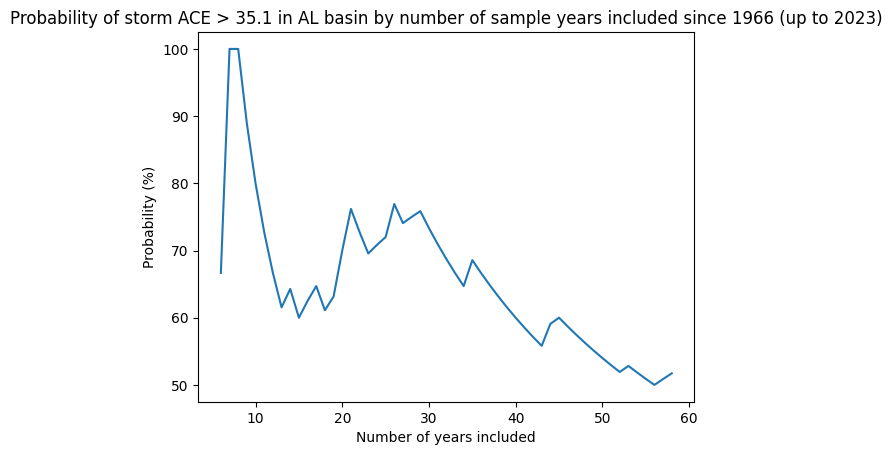

In [668]:
probabilities = {}
for min_year in range(1966, 2019):

    # Group ACE values by year
    ace_by_year = {}
    for atcf_id, ace in ace_by_atcf_id.items():
        year = int(atcf_id[-4:])  # Extract the year from the ATCF ID
        if year >= min_year:  # Only consider years greater than or equal to min_year
            if year not in ace_by_year:
                ace_by_year[year] = []
            ace_by_year[year].append(ace)

    # Calculate the number of storms with higher ACE than forecast_selected_storm_ace
    num_storms_higher_ace = 0
    years_with_higher_ace = []
    for year, ace_values in ace_by_year.items():
        if year >= min_year:  # Only consider years greater than or equal to min_year
            if any(ace > forecast_selected_storm_ace for ace in ace_values):
                num_storms_higher_ace += len([ace for ace in ace_values if ace > forecast_selected_storm_ace])
                years_with_higher_ace.append(year)

    # Calculate the probability
    num_years = len(ace_by_year)
    probability = num_storms_higher_ace / num_years
    probabilities[num_years] = probability

    # Print the results
    print(f"Number of storms in AL basin with higher ACE than {forecast_selected_storm_ace} (since {min_year}): {num_storms_higher_ace}")
    print(f"Years with storms in AL basin having ACE > {forecast_selected_storm_ace} (since {min_year}): {years_with_higher_ace}")
    print(f"% of years having storms in AL basin having ACE > {forecast_selected_storm_ace} (since {min_year}): {probability*100:.1f} %")


# Sort the probabilities by number of years in descending order
sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[0], reverse=True)

# Separate the number of years and probabilities into different lists
num_years = [item[0] for item in sorted_probabilities]
probabilities_percent = [item[1] * 100 for item in sorted_probabilities]

# Plot the line chart
plt.plot(num_years, probabilities_percent)
plt.xlabel('Number of years included')
plt.ylabel('Probability (%)')
plt.title(f'Probability of storm ACE > {forecast_selected_storm_ace} in AL basin by number of sample years included since 1966 (up to 2023)')
plt.show()

In [669]:
# use this to normalize a 1-d array
def normalize(matrix):
    norm = np.linalg.norm(matrix, 1)
    if norm == 0:  # Avoid division by zero
        return np.zeros_like(matrix)
    matrix = matrix/norm 
    return matrix

# use exponential decay (the difference passed should always be positive)
def custom_kernel(difference, rate):
    #return (1.0 / difference)
    return np.exp(-rate * difference)

def get_min_pair_by_value(d):
    # Find the key/value pair with the minimum value from a dict
    return min(d.items(), key=lambda x: x[1])

def mean_squared_error(predictions, actual_values):
    # Ensure both dictionaries have the same keys
    common_keys = set(predictions.keys()) & set(actual_values.keys())
    
    # Calculate the squared differences and sum them
    squared_diff_sum = sum((predictions[key] - actual_values[key])**2 for key in common_keys)
    
    # Calculate the mean squared error
    mse = squared_diff_sum / len(common_keys)
    
    return mse

In [670]:
### This should be done regularly (after every day?) to get lower variance and proper decay values considering the time until to the end of the season

### TUNING & VALIDATION for decay rates and expected ACE (for this far out in year) ###

### do tuning on a partial dataset to calculate MSE and then do validation on the remaining dataset
### to make sure MSE is not too far off (this will be an estimate of the additional error/uncertainty in the tuning)

years = list(season_ace_to_time_end.keys())
years_above_real_time_ace = sorted(list(season_ace_above_real_time.keys()))

# Calculate the size of the first list (80%)
tuning_list_size = int(len(years) * 0.8)

# Randomly shuffle the original list
random.shuffle(years)

# Split the list into two new lists
years_tuning = years[:tuning_list_size]
years_validation = years[tuning_list_size:]
print(f"Tuning years: ", years_tuning)
print(f"Validation years: ", years_validation)

Tuning years:  [2003, 1971, 2013, 2000, 1985, 2010, 1973, 1996, 2021, 2016, 1983, 2017, 1995, 1974, 2005, 2015, 1969, 2020, 1994, 2006, 1982, 1967, 2023, 1984, 2022, 1987, 1979, 1991, 2007, 1972, 2012, 1986, 1976, 2014, 1968, 1966, 1975, 1981, 1977, 1980, 1997, 1990, 1993, 2018, 1998, 1992]
Validation years:  [1989, 2009, 2019, 1999, 2002, 1978, 2011, 2008, 2004, 1970, 2001, 1988]


In [671]:
# exponential decay weights
rates_to_try = list(np.round(np.arange(0.1, 0.5, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_ACE_by_tuning_year = {}
    # tune over only years for validation set
    for tuning_year in years_tuning:
        # for tuning this is the season_ace_to_time_end[tuning_year]
        tuning_ACE = season_ace_to_time_end[tuning_year]

        tuning_diff_season_ace_to_time_end = {}

        for [year, ace] in season_ace_to_time_end.items():
            if year in years_tuning and year != tuning_year:
                tuning_diff_season_ace_to_time_end[year] = tuning_ACE - ace

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in tuning_diff_season_ace_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected ACE using normalized weights
        expected_ACE = 0.0
        for [x, year] in list(enumerate(tuning_diff_season_ace_to_time_end)):
            expected_ACE += (weights_normalized[x] * season_ace[year])
        #print(tuning_diff_season_ace_to_time_end)

        expected_ACE_by_tuning_year[tuning_year] = expected_ACE
    
    # calculate the MSE for this rate
    #print(expected_ACE_by_tuning_year)
    mse = mean_squared_error(expected_ACE_by_tuning_year, season_ace)
    mse_by_rate[rate] = mse

In [672]:
tuning_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Validation) Rate , MSE (minimum) for tuning dataset: {tuning_min_pair}")

(Validation) Rate , MSE (minimum) for tuning dataset: (0.257, 237.30563098663828)


In [673]:
# TUNING above has minimum MSE for:
# Rate: 0.14, MSE: 578.8630529802942

In [674]:
## VALIDATION
# exponential decay weights
rates_to_try = list(np.round(np.arange(0.05, 0.5, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_ACE_by_validation_year = {}
    for validation_year in years_validation:
        # for validation this is the season_ace_to_time_end[validation_year]
        validation_ACE = season_ace_to_time_end[validation_year]

        validation_diff_season_ace_to_time_end = {}

        for [year, ace] in season_ace_to_time_end.items():
            if year in years_validation and year != validation_year:
                validation_diff_season_ace_to_time_end[year] = validation_ACE - ace

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in validation_diff_season_ace_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)
        if rate == 1.184:
            print(weights_normalized)
        # Calculate expected ACE using normalized weights
        expected_ACE = 0.0
        for [x, year] in list(enumerate(validation_diff_season_ace_to_time_end)):
            expected_ACE += (weights_normalized[x] * season_ace[year])

        expected_ACE_by_validation_year[validation_year] = expected_ACE
    
    # calculate the MSE for this rate
    #print(expected_ACE_by_validation_year)
    mse = mean_squared_error(expected_ACE_by_validation_year, season_ace)
    mse_by_rate[rate] = mse
    

In [675]:
validation_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Validation) Rate : MSE (minimum) for validation dataset: {validation_min_pair}")

(Validation) Rate : MSE (minimum) for validation dataset: (0.377, 505.2220731654134)


In [676]:
# for validation, the minimum MSE:
# Rate: 0.102, MSE: 439.9012525009955
# from the validation-tuning set above, the tuning Rate: 0.14, MSE: 450.0207460685012

rmse_tuning = pow(tuning_min_pair[1], 0.5)
rmse_validation = pow(validation_min_pair[1], 0.5)
diff_rmse = abs(rmse_tuning - rmse_validation)
print(f"RMSE tuning: {rmse_tuning:.2f}")
print(f"RMSE validation: {rmse_validation:.2f}")
print(f"Difference of RMSE(tuning) - RMSE(validation): {diff_rmse:.2f}")

RMSE tuning: 15.40
RMSE validation: 22.48
Difference of RMSE(tuning) - RMSE(validation): 7.07


In [677]:
# FINAL TUNING

# exponential decay weights
rates_to_try = list(np.round(np.arange(0.05, 0.5, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_ACE_by_tuning_year = {}
    # tune over all years
    for tuning_year in years:
        # for tuning this is the season_ace_to_time_end[tuning_year]
        tuning_ACE = season_ace_to_time_end[tuning_year]

        tuning_diff_season_ace_to_time_end = {}

        for [year, ace] in season_ace_to_time_end.items():
            if year in years and year != tuning_year:
                tuning_diff_season_ace_to_time_end[year] = tuning_ACE - ace

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in tuning_diff_season_ace_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected ACE using normalized weights
        expected_ACE = 0.0
        for [x, year] in list(enumerate(tuning_diff_season_ace_to_time_end)):
            expected_ACE += (weights_normalized[x] * season_ace[year])
        #print(tuning_diff_season_ace_to_time_end)

        expected_ACE_by_tuning_year[tuning_year] = expected_ACE
    
    # calculate the MSE for this rate
    #print(expected_ACE_by_tuning_year)
    mse = mean_squared_error(expected_ACE_by_tuning_year, season_ace)
    mse_by_rate[rate] = mse
    #print(f"Rate: {rate}, MSE: {mse}")

final_tuning_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Tuning Final) Rate : MSE (minimum) for all past years: {final_tuning_min_pair}")

(Tuning Final) Rate : MSE (minimum) for all past years: (0.149, 222.33360298012784)


In [678]:
# minimum is Rate: 0.147, MSE: 518.519969751831
mse_final_tuning = final_tuning_min_pair[1]
rate_final_tuning = final_tuning_min_pair[0]
print(f"Rate final tuning: {rate_final_tuning:0.4f}")
print(f"MSE final tuning: {mse_final_tuning:.2f}")
rmse_final_tuning = pow(mse_final_tuning,0.5)
print("")
print(f"RMSE final tuning: {rmse_final_tuning:.2f}")

Rate final tuning: 0.1490
MSE final tuning: 222.33

RMSE final tuning: 14.91


In [679]:
def calculate_expected_ACE(this_season_end = season_ace_to_time_end, repeat_counts = None):
    diff_season_ace_to_time_end = {}

    for [year, ace] in this_season_end.items():
        diff_season_ace_to_time_end[year] = present_ACE - ace

    # exponential decay weights
    #rates_to_try = list(np.round(np.arange(0.080, 0.205, 0.005),3))
    rates_to_try = [rate_final_tuning]

    expected_ACE_by_rate = {}
    weights_normalized_by_year = {}
    # Calculate weights for each decay rate
    for rate in rates_to_try:
        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in diff_season_ace_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # store weights by year for useful statistics
        weights_normalized_by_year = {}

        weights_total = 0.0
        # Calculate expected ACE using normalized weights
        expected_ACE = 0.0
        for [x, year] in list(enumerate(diff_season_ace_to_time_end)):
            weights_normalized_by_year[year] = weights_normalized[x]
            if repeat_counts:
                repeat_count = repeat_counts[year]
                # can't just multiply by repeat_count without renormalizing
                expected_ACE += (repeat_count * (weights_normalized[x] * season_ace[year]))
                weights_total += repeat_count * weights_normalized[x]
            else:
                expected_ACE += (weights_normalized[x] * season_ace[year])
                weights_total += weights_normalized[x]

        # renormalize (only affected if repeat_counts is set)
        if weights_total == 0:
            expected_ACE_by_rate[rate] = 0
        else:
            expected_ACE_by_rate[rate] = expected_ACE / weights_total

    expected_ACE = expected_ACE_by_rate[rate_final_tuning]

    return [expected_ACE, weights_normalized_by_year]


In [680]:
np.sum(list(weights_normalized_by_year.values()))

1.0

In [681]:
weights_normalized_by_year

{1969: 0.0005285715049658364,
 1980: 0.010661459415378726,
 1995: 0.0003377929365857417,
 1996: 0.18355884827441576,
 1998: 0.2102138435303885,
 1999: 0.17863467796367652,
 2003: 0.2026028816631464,
 2004: 4.144234512072007e-06,
 2005: 0.0005525288195466797,
 2008: 0.025527985350732613,
 2010: 0.1353958642223196,
 2017: 2.582745553452295e-05,
 2020: 0.0040086331189794246,
 2021: 0.01661461641921068,
 2023: 0.031332325090606794}

In [682]:
weights_normalized_by_year

{1969: 0.0005285715049658364,
 1980: 0.010661459415378726,
 1995: 0.0003377929365857417,
 1996: 0.18355884827441576,
 1998: 0.2102138435303885,
 1999: 0.17863467796367652,
 2003: 0.2026028816631464,
 2004: 4.144234512072007e-06,
 2005: 0.0005525288195466797,
 2008: 0.025527985350732613,
 2010: 0.1353958642223196,
 2017: 2.582745553452295e-05,
 2020: 0.0040086331189794246,
 2021: 0.01661461641921068,
 2023: 0.031332325090606794}

In [683]:

list(weights_normalized_by_year.keys())

[1969,
 1980,
 1995,
 1996,
 1998,
 1999,
 2003,
 2004,
 2005,
 2008,
 2010,
 2017,
 2020,
 2021,
 2023]

In [684]:
weights_normalized_by_year

{1969: 0.0005285715049658364,
 1980: 0.010661459415378726,
 1995: 0.0003377929365857417,
 1996: 0.18355884827441576,
 1998: 0.2102138435303885,
 1999: 0.17863467796367652,
 2003: 0.2026028816631464,
 2004: 4.144234512072007e-06,
 2005: 0.0005525288195466797,
 2008: 0.025527985350732613,
 2010: 0.1353958642223196,
 2017: 2.582745553452295e-05,
 2020: 0.0040086331189794246,
 2021: 0.01661461641921068,
 2023: 0.031332325090606794}

Sampled data: {1969: 102.09750000000001, 1980: 122.26, 1995: 191.50750000000002, 1996: 141.36, 1998: 142.27, 1999: 141.1775, 2003: 148.57750000000001, 2004: 221.04250000000002, 2005: 188.205, 2008: 128.12, 2010: 139.3175, 2017: 208.76250000000002, 2020: 115.69500000000001, 2021: 125.23750000000001, 2023: 129.495}
ACE Median of select years: 176.275
Valid until: 2024-10-30 00:00:00
ACE, Real-time + storm model forecast: 145.3
Tuned decay rate: 0.149

Expected ACE (weight historical ACE using exponential decay): 171.57


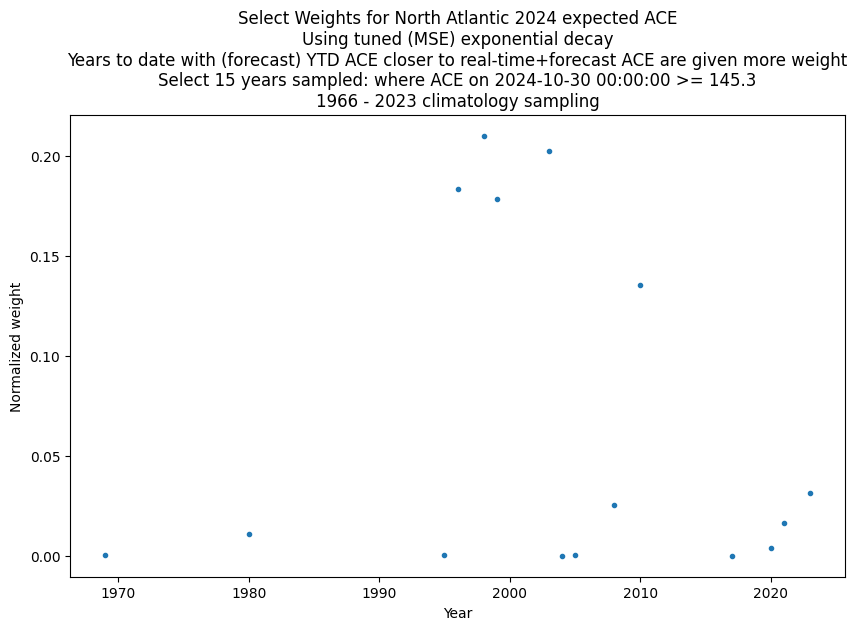

Top 10 weights (sorted by weight)
----------------------------------------
Rank  |  Year  |  Weight  |  Season ACE
----------------------------------------
   1  |  1998  |  0.210   |  181.16
   2  |  2003  |  0.203   |  176.28
   3  |  1996  |  0.184   |  166.06
   4  |  1999  |  0.179   |  176.53
   5  |  2010  |  0.135   |  165.48
   6  |  2023  |  0.031   |  146.79
   7  |  2008  |  0.026   |  145.72
   8  |  2021  |  0.017   |  145.56
   9  |  1980  |  0.011   |  148.94
  10  |  2020  |  0.004   |  180.37


In [685]:
# real-time ACE plus forecast ace (until ace_time_end_str)
# use a manually entered value
present_ACE = 122.65
# or the value from the forecast
present_ACE = total_ace_until_forecast
####################################

pop_ace_values = list(season_ace_above_real_time.values())
n_pop_ace_values = len(pop_ace_values)
num_sample_years = n_pop_ace_values  # Number of samples
# Sample years only where above real time
select_keys = list(season_ace_above_real_time.keys())

# Use the selected keys to access corresponding values (these are the ACE values until current time)
select_values = [season_ace_to_time_end[key] for key in select_keys]

sampled_data = {key: value for key, value in zip(select_keys, select_values)}

# Calculate the statistic of interest for the resampled dataset
# We pass the until real time values for each year's ACE that is above real time
# Then we calculate the ACE delta (how far it is from the present years's ACE at this time)
# from that we can calculate the corresponding model weight using the exponential decay model (exponential decay's rate was tuned prior to minimize RMSE)
# Then normalize using the entire season's ace value (accounting for the number of season repeats in this sample)
expected_ACE, weights_normalized_by_year = calculate_expected_ACE(this_season_end=sampled_data, repeat_counts=None)

ace_stddev = np.std(pop_ace_values)
ace_mean = np.mean(pop_ace_values)
ace_median = np.median(pop_ace_values)
z_score = (expected_ACE - ace_mean) / ace_stddev
print("Sampled data:", sampled_data)
print("ACE Median of select years:", ace_median)

sorted_years = sorted(years)

print(f"Valid until:", ace_time)
print(f"ACE, Real-time + storm model forecast: {total_ace_until_forecast:3.1f}")
print("Tuned decay rate:", rate_final_tuning)
print("")
print(f"Expected ACE (weight historical ACE using exponential decay): {expected_ACE:3.2f}")

expected_ACE_years = list(weights_normalized_by_year.keys())
expected_ACE_weights = list(weights_normalized_by_year.values())

# Plot the values of the weights
plt.figure(figsize=(10, 6))
plt.plot(expected_ACE_years, expected_ACE_weights, marker='.', linestyle='')
plt.xlabel('Year')
plt.ylabel('Normalized weight')
min_year = min(season_ace_to_time_end.keys())
max_year = max(season_ace_to_time_end.keys())

plt.title(f'Select Weights for North Atlantic 2024 expected ACE\nUsing tuned (MSE) exponential decay\nYears to date with (forecast) YTD ACE closer to real-time+forecast ACE are given more weight\nSelect {n_pop_ace_values} years sampled: where ACE on {ace_time_end_str} >= {total_ace_until_forecast}\n{min_year} - {max_year} climatology sampling')
plt.show()

# Print out the ranking of weights
num_weights_in_table = 10

# Sort the dictionary items by values in descending order
sorted_weights_by_year = dict(
    sorted(weights_normalized_by_year.items(), key=lambda x: float(x[1]), reverse=True)[:num_weights_in_table]
)

# Convert NumPy values to regular Python types
sorted_weights_by_year = {int(year): float(weight) for year, weight in sorted_weights_by_year.items()}

# Print the table header
print(f"Top {num_weights_in_table} weights (sorted by weight)")
print("-" * 40)
print("Rank  |  Year  |  Weight  |  Season ACE")
print("-" * 40)

# Iterate through the first X items and print the rank, year, and weight
for rank, (year, weight) in enumerate(sorted_weights_by_year.items(), start=1):
    print(f"{rank:4}  |  {year:4}  |  {weight:.3f}   |  {season_ace[year]:3.2f}")

ACE=160 (exp. decay) %: 99.11 %
ACE=258 (exp. decay) %: 0.00 %
ACE=159 (exp. decay) %: 99.33 %
ACE=160 (exp. decay) %: 99.11 %
ACE=145 (excluding years below real time ACE) %: 100.00 %
ACE=146 (excluding years below real time ACE) %: 100.00 %
ACE=147 (excluding years below real time ACE) %: 99.99 %
ACE=148 (excluding years below real time ACE) %: 99.95 %
ACE=149 (excluding years below real time ACE) %: 99.89 %
ACE=150 (excluding years below real time ACE) %: 99.86 %
ACE=151 (excluding years below real time ACE) %: 99.83 %
ACE=152 (excluding years below real time ACE) %: 99.81 %
ACE=153 (excluding years below real time ACE) %: 99.80 %
ACE=154 (excluding years below real time ACE) %: 99.80 %
ACE=155 (excluding years below real time ACE) %: 99.77 %
ACE=156 (excluding years below real time ACE) %: 99.71 %
ACE=157 (excluding years below real time ACE) %: 99.62 %
ACE=158 (excluding years below real time ACE) %: 99.50 %
ACE=159 (excluding years below real time ACE) %: 99.33 %


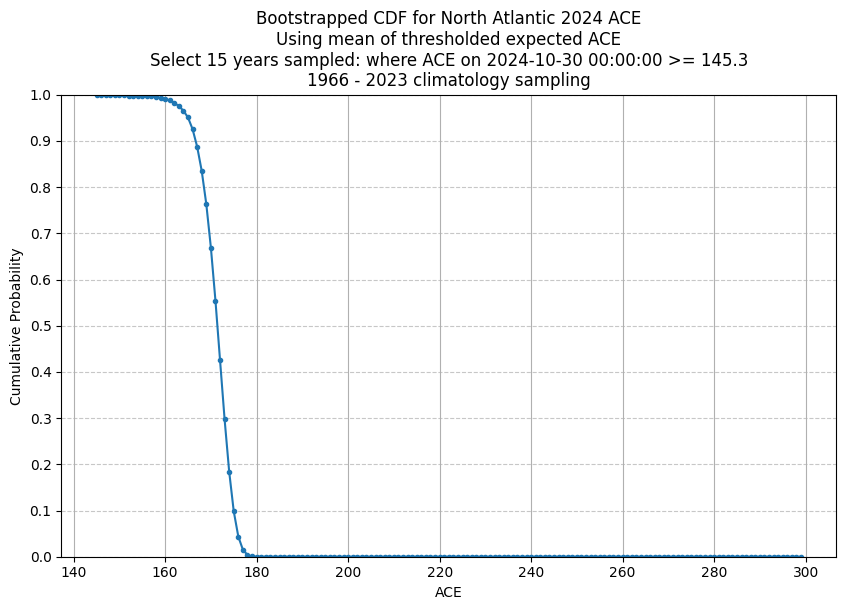


ACE=159 (excluding years below real time ACE) %: 91.12 %
ACE=160 (excluding years below real time ACE) %: 91.12 %
ACE=145 (excluding years below real time ACE) %: 100.00 %
ACE=146 (excluding years below real time ACE) %: 99.98 %
ACE=147 (excluding years below real time ACE) %: 99.56 %
ACE=148 (excluding years below real time ACE) %: 99.56 %
ACE=149 (excluding years below real time ACE) %: 91.12 %
ACE=150 (excluding years below real time ACE) %: 91.12 %
ACE=151 (excluding years below real time ACE) %: 91.12 %
ACE=152 (excluding years below real time ACE) %: 91.12 %
ACE=153 (excluding years below real time ACE) %: 91.12 %
ACE=154 (excluding years below real time ACE) %: 91.12 %
ACE=155 (excluding years below real time ACE) %: 91.12 %
ACE=156 (excluding years below real time ACE) %: 91.12 %
ACE=157 (excluding years below real time ACE) %: 91.12 %
ACE=158 (excluding years below real time ACE) %: 91.12 %
ACE=159 (excluding years below real time ACE) %: 91.12 %


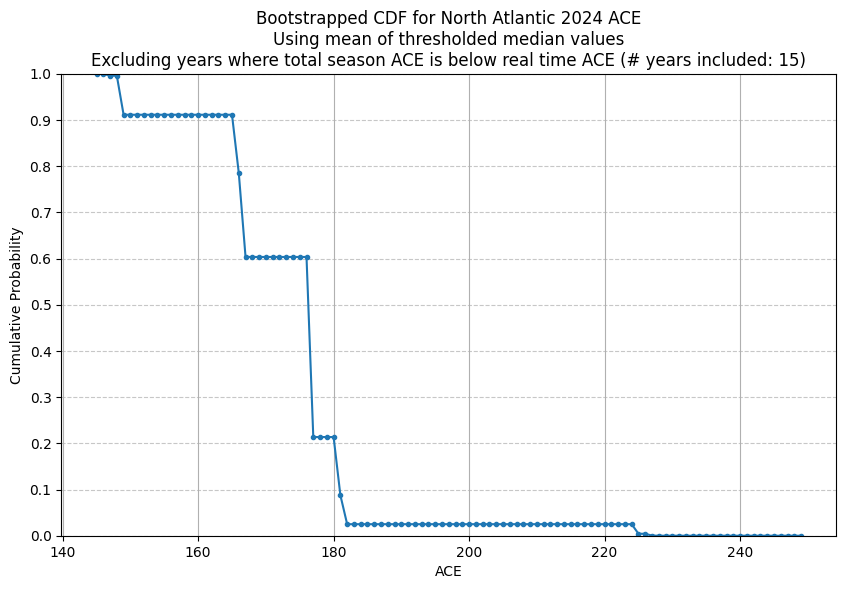


% chance of ACE=159 using average of two probabilities: 95.23%

Statistics for 15, excluding years with season ACE < real time ACE:
μ: 180.70
median: 176.28



In [686]:
min_year = min(season_ace_to_time_end.keys())
max_year = max(season_ace_to_time_end.keys())


# Specify the confidence level (e.g., 90% CI)
confidence_level = 0.7

# use bootstrapping instead for CI

# Number of bootstrap samples to generate
num_samples = 100000
#num_samples = 50

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = expected_ACE

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for CDF estimation
#values_of_interest = list(range(round(real_time_ACE), round(max(pop_ace_values)), 1))
values_of_interest = list(range(np.floor(real_time_ACE).astype(int), round(300), 1))

# store when the median is greater than each value of interest
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement
    
    # cannot do random choice on a dict...
    #resampled_data = np.random.choice(season_ace_above_real_time, size=len(season_ace_above_real_time), replace=True)
    
    num_sample_years = n_pop_ace_values  # Number of samples you want to draw
    # Randomly select keys from the dictionary with replacement
    # Sample years only where above real time
    random_keys = random.choices(list(season_ace_above_real_time.keys()), k=num_sample_years)
    
    # Use the selected keys to access corresponding values (these are the ACE values until current time)
    random_values = [season_ace_to_time_end[key] for key in random_keys]
    
    # since I need to pass a dict that should have multiple keys repeated, do something extra to keep track of the 'repeats'
    repeat_counts = dict(Counter(random_keys))
    
    resampled_data = {key: value for key, value in zip(random_keys, random_values)}

    # Calculate the statistic of interest for the resampled dataset
    # We pass the until real time values for each year's ACE that is above real time
    # Then we calculate the ACE delta (how far it is from the present years's ACE at this time)
    # from that we can calculate the corresponding model weight using the exponential decay model (exponential decay's rate was tuned prior to minimize RMSE)
    # Then normalize using the entire season's ace value (accounting for the number of season repeats in this sample)
    resampled_statistic, weights_normalized_by_year = calculate_expected_ACE(this_season_end=resampled_data, repeat_counts=repeat_counts)
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic
    
    # Threshold on the values of interest using the expected ACE
    binary_outcome = []
    for value in values_of_interest:
        if resampled_statistic < value:
            binary_outcome.append(0)
        else:
            binary_outcome.append(1)
    binary_outcomes[i] = binary_outcome
    
# Calculate the CDF for each value of interest (using the average of the thresholded binary outcomes)
cdf = np.mean(binary_outcomes, axis=0)

selected_ace_values = [159.6, 258.47]
for selected_ace in selected_ace_values:
    rounded_ace = int(round(selected_ace))
    print(f"ACE={rounded_ace} (exp. decay) %: {cdf[values_of_interest.index(rounded_ace)]*100:2.2f} %")
    
print(f"ACE=159 (exp. decay) %: {cdf[values_of_interest.index(159)]*100:2.2f} %")
print(f"ACE=160 (exp. decay) %: {cdf[values_of_interest.index(160)]*100:2.2f} %")
prob_exp = cdf[values_of_interest.index(159)]
for x in range(145, 160):
    print(f"ACE={x} (excluding years below real time ACE) %: {cdf[values_of_interest.index(x)]*100:2.2f} %")

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, cdf, marker='.', linestyle='-')
plt.xlabel('ACE')
plt.ylabel('Cumulative Probability')
plt.title(f'Bootstrapped CDF for North Atlantic 2024 ACE\nUsing mean of thresholded expected ACE\nSelect {n_pop_ace_values} years sampled: where ACE on {ace_time_end_str} >= {total_ace_until_forecast}\n{min_year} - {max_year} climatology sampling')


# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()

# Calculate the lower and upper bounds of the confidence interval
alpha = 1 - confidence_level
lower_bound = np.percentile(resampled_statistics, 100 * alpha / 2)
upper_bound = np.percentile(resampled_statistics, 100 * (1 - alpha / 2))

# Print the results
#print(f"(bootstrapped) CI using expected value ({confidence_level*100:2.1f}%): [{lower_bound:3.2f}, {upper_bound:3.2f}]")

# use bootstrapping instead for CI





## SIMPLE ABOVE REAL TIME




# Number of bootstrap samples to generate
num_samples = 100000

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = ace_median

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for CDF estimation
values_of_interest = list(range(np.floor(real_time_ACE).astype(int), round(max(pop_ace_values)), 1))

# Initialize an array to store CDF from bootstraps
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement
    resampled_data = np.random.choice(pop_ace_values, size=len(pop_ace_values), replace=True)
    
    # Calculate the statistic of interest for the resampled dataset
    resampled_statistic = np.median(resampled_data)
    
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic

    # Threshold on the values of interest using the expected ACE
    binary_outcome = []
    for value in values_of_interest:
        if resampled_statistic < value:
            binary_outcome.append(0)
        else:
            binary_outcome.append(1)
    binary_outcomes[i] = binary_outcome
    
# Calculate the CDF for each value of interest (using the average of the thresholded binary outcomes)
cdf = np.mean(binary_outcomes, axis=0)
print("")

print(f"ACE=159 (excluding years below real time ACE) %: {cdf[values_of_interest.index(159)]*100:2.2f} %")
print(f"ACE=160 (excluding years below real time ACE) %: {cdf[values_of_interest.index(160)]*100:2.2f} %")
for x in range(145, 160):
    print(f"ACE={x} (excluding years below real time ACE) %: {cdf[values_of_interest.index(x)]*100:2.2f} %")
prob_realtime = cdf[values_of_interest.index(159)]

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, cdf, marker='.', linestyle='-')

plt.xlabel('ACE')
plt.ylabel('Cumulative Probability')
plt.title(f'Bootstrapped CDF for North Atlantic 2024 ACE\nUsing mean of thresholded median values\nExcluding years where total season ACE is below real time ACE (# years included: {n_pop_ace_values})')

# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)

plt.grid(True)
plt.show()
    
# not useful with long tail
# Specify the confidence level (e.g., 90% CI)
confidence_level = 0.54

# Calculate the lower and upper bounds of the confidence interval
alpha = 1 - confidence_level
lower_bound = np.percentile(resampled_statistics, 100 * alpha / 2)
upper_bound = np.percentile(resampled_statistics, 100 * (1 - alpha / 2))


# Print the results
#print(f"(bootstrapped) CI using median ({confidence_level*100:2.1f}%): [{lower_bound:3.2f}, {upper_bound:3.2f}]")
print("")
avg_of_two_at_159 = (prob_realtime + prob_exp) / 2
print(f"% chance of ACE=159 using average of two probabilities: {avg_of_two_at_159*100:2.2f}%")

print("")
print(f"Statistics for {n_pop_ace_values}, excluding years with season ACE < real time ACE:")
print(f"μ: {ace_mean:3.2f}")
print(f"median: {ace_median:3.2f}")

# not as useful since it doesn't handle constraints well so don't use general statistics below for CI:
#print("σ:", ace_stddev)
#print("Z score for expected ACE:", z_score)
#ci_lower = expected_ACE - (critical_value * ace_stddev)
#ci_upper = expected_ACE + (critical_value * ace_stddev)
#print(f"CI({confidence_level}) = [ {ci_lower} , {ci_upper} ]")


# expect the tuned decay rate should automatically increase as the season passes
#   this means, later in the season it will be more selective in using years that have ACE that are very close to the present
#   as opposed to early in the season when the years will be more of an average
# for instance on Sept 24 06Z it was 0.147, and on Sept 25 00Z it was 0.171
print("")

In [687]:
# diagnostics for model predictiveness as the season progresses
expected_ACE_upper = expected_ACE + rmse_final_tuning
expected_ACE_lower = expected_ACE - rmse_final_tuning
#print(f"Range using RMSE (without validation RMSE): {expected_ACE_lower} : {expected_ACE_upper}")
expected_ACE_upper_with_validation_z1 = expected_ACE + (rmse_final_tuning + diff_rmse)
expected_ACE_lower_with_validation_z1 = max(expected_ACE - (rmse_final_tuning + diff_rmse), real_time_ACE)
expected_ACE_upper_with_validation_z2 = expected_ACE + 2 * (rmse_final_tuning + diff_rmse)
expected_ACE_lower_with_validation_z2 = max(expected_ACE - 2 * (rmse_final_tuning + diff_rmse), real_time_ACE)
print(f"Range using RMSE (with validation RMSE):    {expected_ACE_lower_with_validation_z1} : {expected_ACE_upper_with_validation_z1}")

Range using RMSE (with validation RMSE):    149.5818978506659 : 193.5484443052388


In [688]:
# weight two predictors by sample size
# first predictor must account for unequal weights (inflating the sample size)
# consider for reference where all weights are given equal value (1/n)
#    then, for a weight that is less than or equal to 1/10 of (1/n),
#    let us consider such a weight as not contributing enough and is inflating the sample size
num_total_weights = len(sorted_weights_by_year)
contributing_threshold = (1/10) * (1/num_total_weights)
num_contributing_weights = 0
for rank, (year, weight) in enumerate(sorted_weights_by_year.items(), start=1):
    if weight > contributing_threshold:
        num_contributing_weights += 1
n1 = num_contributing_weights
n2 = n_pop_ace_values
w1 = n1 / (n1 + n2)
w2 = n2 / (n1 + n2)
# normalize weights
w1 = w1 / (w1 + w2)
w2 = w2 / (w1 + w2)
p_weighted = prob_exp*w1 + prob_realtime*w2
#print(f"(ACE=126) Weighting the two predictors: (weighting Exp: {w1:.1f}, Realtime: {w2:.1f}): {p_weighted*100:.2f}%")
print(f"(ACE=159) Weighting the two predictors: (weighting Exp: {w1:.1f}, Realtime: {w2:.1f}): {p_weighted*100:.2f}%")

(ACE=159) Weighting the two predictors: (weighting Exp: 0.4, Realtime: 0.6): 94.20%


In [689]:
with open('season_ace.csv', 'w') as file:
    for [year,ace] in season_ace.items():
        file.write(f"{year}, {ace}\n")

In [690]:
raise Exception('STOP HERE')

Exception: STOP HERE

In [ ]:
# via wikipedia
# as of Oct. 23, 2024
current_fatalities = 361
#current_economic_damages_in_2024_usd = 41.779e9
#current_economic_damages_in_2024_usd = 179e6 + 6.86e9 + 1e6 + 2.8e9 + 24.3e6 + 1.5e9 + 22e9
#current_economic_damages_in_2024_usd = 179e6 + 6.86e9 + 1e6 + 2.8e9 + 24.3e6 + 1.5e9 + 34e9 + 125e9
#current_economic_damages_in_2024_usd = 179e6 + 6.86e9 + 1e6 + 2.8e9 + 24.3e6 + 1.5e9 + 34e9
#current_economic_damages_in_2024_usd = 179e6 + 6.86e9 + 1e6 + 2.8e9 + 24.3e6 + 1.5e9 + 27.5e9
current_economic_damages_in_2024_usd = 165e6 + 7.74e9 + 1e6 + 7e9 + 150e6 + 1.5e9 + 45e9 + 10.9e6 + 50e9


print("Current damages 2024:", current_economic_damages_in_2024_usd)
season_start_time_str = "2024-06-01 00:00:00"
season_start_time = datetime.fromisoformat(season_start_time_str)
season_end_time_str = "2024-12-01 00:00:00"
season_end_time = datetime.fromisoformat(season_end_time_str)
ratio_season_elapsed = (ace_time - season_start_time) / (season_end_time - season_start_time)
ratio_season_remaining = 1 - ratio_season_elapsed


In [ ]:
ratio_season_remaining

In [ ]:
current_economic_damages_in_2024_usd

In [ ]:
raise Exception('STOP HERE')

In [ ]:
def load_data_from_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data


fatalities = load_data_from_json('fatalities_min.json')
economic_damages_in_2024_usd = load_data_from_json('cleaned_economic_damages_min_in_2024usd.json')

expected_fatalities = 0
expected_damages = 0
total_weights = 0
for year, weight in weights_normalized_by_year.items():
    year_str = str(year)
    expected_fatalities += weight * fatalities[year_str]
    expected_damages += weight * economic_damages_in_2024_usd[year_str]
    total_weights += weight
    
print(f"Expected fatalities in 2024 by ACE model: {expected_fatalities} deaths")
print(f"Expected economic damages in 2024 by ACE model: ${expected_damages} (2024 USD)")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyRegressor
from scipy.stats import pearsonr, norm
import scipy.stats as stats

import matplotlib.pyplot as plt
import math

baseline_years = 60
season_ace_above_real_time_recent = {year: value for year, value in season_ace_above_real_time.items() if year >= max(season_ace_above_real_time.keys()) - baseline_years}

# Convert string years to integer years in fatalities and economic_damages_in_2024_usd
fatalities = {int(k): v for k, v in fatalities.items()}
economic_damages_in_2024_usd = {int(k): v for k, v in economic_damages_in_2024_usd.items()}

# Filter data to include only years present in all three dictionaries
years = set(season_ace_above_real_time_recent.keys()) & set(fatalities.keys()) & set(economic_damages_in_2024_usd.keys())

# Create DataFrames
df_fatalities = pd.DataFrame({'Year': list(years), 
                             'ACE': [season_ace_above_real_time_recent[y] for y in years], 
                             'Fatalities': [fatalities[y] for y in years]})

df_economic = pd.DataFrame({'Year': list(years), 
                           'ACE': [season_ace_above_real_time_recent[y] for y in years], 
                           'Economic_Damages': [economic_damages_in_2024_usd[y] for y in years]})

# Parametric Model (e.g., linear regression)
def exceedance_probability(model, x):
    mean, std = model.predict(), model.std()
    return 1 - norm.cdf(x, loc=mean, scale=std)

# Function to perform statistical tests and model fitting
def analyze_data(df, target):
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(df[['ACE']], df[target], test_size=0.2, random_state=42)

    models = {
        'Mean': DummyRegressor(strategy='mean'),
        'Linear': LinearRegression(),
        'Logarithmic': make_pipeline(FunctionTransformer(np.log), LinearRegression()),  # Apply log transformation
        'Exponential': make_pipeline(FunctionTransformer(np.exp), LinearRegression()),
        'Polynomial (Degree 2)': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
        'Polynomial (Degree 3)': make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
    }
    
    # Baseline model: predict the mean
    baseline_model = np.mean(df[target])
    baseline_mse = mean_squared_error(df[target], [baseline_model] * len(df))
    baseline_rmse = np.power(baseline_mse, 0.5)
    baseline_r2 = 0  # R-squared is 0 for a constant model

    # Perform statistical tests and model fitting
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.power(mse, 0.5)
        results[name] = {
            'R-Squared': r2_score(y_val, y_pred),
            'MSE': round(mean_squared_error(y_val, y_pred)),
            'RMSE': round(rmse),
            'p-value': pearsonr(df['ACE'], df[target])[1],
            'model': model
        }

    # Determine best model
    best_model = max(results, key=lambda x: results[x]['R-Squared'])

    return results, best_model

# Analyze fatalities data
fatalities_results, best_fatalities_model = analyze_data(df_fatalities, 'Fatalities')

# Analyze economic damages data
economic_results, best_economic_model = analyze_data(df_economic, 'Economic_Damages')

# Print results
print('Fatalities Analysis:')
for model, metrics in fatalities_results.items():
    if model != 'Baseline (Mean)':
        print(f'{model}: R-Squared = {metrics["R-Squared"]:.3f}, MSE = {metrics["MSE"]}, RMSE = {metrics["RMSE"]}, p-value = {metrics["p-value"]:.3f}')
    else:
        print(f'{model}: R-Squared = {metrics["R-Squared"]:.3f}, MSE = {metrics["MSE"]}, RMSE = {metrics["RMSE"]}')

print(f'\nBest Fatalities Model: {best_fatalities_model}')

print('\nEconomic Damages Analysis:')
for model, metrics in economic_results.items():
    if model != 'Baseline (Mean)':
        print(f'{model}: R-Squared = {metrics["R-Squared"]:.3f}, MSE = {metrics["MSE"]}, RMSE = {metrics["RMSE"]}, p-value = {metrics["p-value"]:.3f}')
    else:
        print(f'{model}: R-Squared = {metrics["R-Squared"]:.3f}, MSE = {metrics["MSE"]}, RMSE = {metrics["RMSE"]}')

print(f'\nBest Economic Damages Model: {best_economic_model}')

expected_ace_values = [expected_ACE_lower_with_validation_z2, expected_ACE_lower_with_validation_z1, expected_ACE, expected_ACE_upper_with_validation_z1, expected_ACE_upper_with_validation_z2]
years = [2024] * len(expected_ace_values)
expected_ace_df = pd.DataFrame({'Year': years, 'ACE': expected_ace_values})

print("")
print("Using ACE values of (lower (Z=1), expected (exponential decay), upper):", expected_ace_df)

# Calculate expected values and CI for Fatalities
fatalities_expected = fatalities_results[best_fatalities_model]['model'].predict(expected_ace_df[['ACE']])
fatalities_rmse = fatalities_results[best_fatalities_model]['MSE'] ** 0.5
fatalities_ci = 1 * fatalities_rmse  # z-score of 1

print("")
print('Fatalities Expected Values with CI:')
for year, expected, ci in zip(years, fatalities_expected, [fatalities_ci] * len(df_fatalities)):
    print(f'Year: {year}, Expected: {expected:.2f}, CI: ({max(current_fatalities,expected - ci):.2f}, {expected + ci:.2f})')

# Calculate expected values and CI for Economic Damages
economic_expected = economic_results[best_economic_model]['model'].predict(expected_ace_df[['ACE']])
economic_rmse = economic_results[best_economic_model]['MSE'] ** 0.5
economic_ci = 1 * economic_rmse  # z-score of 1

print('\nEconomic Damages Expected Values with CI:')
for year, expected, ci in zip(years, economic_expected, [economic_ci] * len(df_economic)):
    print(f'Year: {year}, Expected: {expected:.2e}, CI: ({max(current_economic_damages_in_2024_usd, expected - ci):.2e}, {expected + ci:.2e})')


print("")
# Calculate expected values and CI for Fatalities
fatalities_expected = fatalities_results[best_fatalities_model]['model'].predict(expected_ace_df[['ACE']])

if fatalities_expected[-1] < current_fatalities:
    # if model expected is wrong, naively extrapolate by how much of the season has completed
    print("Adjusted fatalities expected by current value (extrapolating naively by season)")
    for x in range(len(fatalities_expected)):
        fatalities_expected[x] = current_fatalities / ratio_season_elapsed
    
fatalities_rmse = fatalities_results[best_fatalities_model]['MSE'] ** 0.5
fatalities_ci = 1 * fatalities_rmse  # z-score of 1
fatalities_exceedance_threshold = 3000

max_fatal_p = 0

print('Fatalities Expected Values with CI and Exceedance Probability:')
for year, expected, ci in zip(years, fatalities_expected, [fatalities_ci] * len(df_fatalities)):
    exceedance_prob = 1 - stats.norm.cdf(fatalities_exceedance_threshold, loc=expected, scale=fatalities_rmse)
    max_fatal_p = max(max_fatal_p, exceedance_prob)
    print(f'Year: {year}, Expected: {max(0, expected):.2f}, CI: ({max(current_fatalities,expected - ci):.2f}, {expected + ci:.2f}),'
          f' Exceedance Prob ({fatalities_exceedance_threshold} fatalities): {exceedance_prob:.4f}')

# Calculate expected values and CI for Economic Damages
economic_expected = economic_results[best_economic_model]['model'].predict(expected_ace_df[['ACE']])
if economic_expected[-1] < current_economic_damages_in_2024_usd:
    print("Adjusted economic expected by current value (extrapolating naively by season)")
    # if model expected is wrong, naively extrapolate by how much of the season has completed
    for x in range(len(economic_expected)):
        economic_expected[x] = current_economic_damages_in_2024_usd / ratio_season_elapsed

economic_rmse = economic_results[best_economic_model]['MSE'] ** 0.5
economic_ci = 1 * economic_rmse  # z-score of 1
economic_exceedance_threshold = 295000000000

max_damages_p = 0
print('\nEconomic Damages Expected Values with CI and Exceedance Probability:')
for year, expected, ci in zip(years, economic_expected, [economic_ci] * len(df_economic)):
    exceedance_prob = 1 - stats.norm.cdf(economic_exceedance_threshold, loc=expected, scale=economic_rmse)
    max_damages_p = max(max_damages_p, exceedance_prob)
    print(f'Year: {year}, Expected: {max(0, expected):.2e}, CI: ({max(0, expected - ci):.2e}, {expected + ci:.2e}),'
          f' Exceedance Prob (${economic_exceedance_threshold:.2e} damages): {exceedance_prob:.4f}')

In [ ]:
season_ace_above_real_time_recent

In [ ]:
# https://manifold.markets/Panfilo/will-a-hurricane-that-strikes-the-u
# model is parabolic so low end values of ACE will not make sense!

# Calculate expected values and CI for Economic Damages
economic_expected = economic_results[best_economic_model]['model'].predict(expected_ace_df[['ACE']])
economic_rmse = economic_results[best_economic_model]['MSE'] ** 0.5
economic_ci = 1 * economic_rmse  # z-score of 1
economic_exceedance_threshold = 150000000000

print('\nEconomic Damages Expected Values with CI and Exceedance Probability:')
for year, expected, ci in zip(years, economic_expected, [economic_ci] * len(df_economic)):
    exceedance_prob = 1 - stats.norm.cdf(economic_exceedance_threshold, loc=expected, scale=economic_rmse)
    print(f'Year: {year}, Expected: {max(0, expected):.2e}, CI: ({max(0, expected - ci):.2e}, {expected + ci:.2e}),'
          f' Exceedance Prob (${economic_exceedance_threshold:.2e} damages): {exceedance_prob:.4f}')

In [ ]:
# https://manifold.markets/JakeLowery/will-the-2024-atlantic-hurricane-se-5j4lfqz5e6
# below related to above question

import numpy as np

def calculate_prompt_probability(criteria_probabilities, num_simulations=1000000):
    N = len(criteria_probabilities)
    k = N // 2 + 1  # majority threshold
    
    simulations = np.random.binomial(1, criteria_probabilities, size=(num_simulations, N))
    majority_met = np.sum(simulations, axis=1) >= k
    
    return np.mean(majority_met)

# other probs from climatology notebook (criteria 2-5)
"""
Through Oct. 24:

# Named Storms in bins: {(11, 15): 24.809602902877057, (16, 20): 74.8769284190714, (21, 25): 0.3134415624643577, (26, 30): 2.71153248615302e-05, (31, 35): 2.6234235499843895e-10, (36, 999): 5.542936781625119e-16}
>= 17 named storms {(17, 99): 40.60731426280947}
>= 10 hurricanes {(10, 99): 100.0}
0.3333333333333333
>= 6 major hurricanes {(6, 99): 4.462491923494765}
>= 2 cat 5 hurricanes {(2, 99): 100.00000000000001}
# Hurricanes in 2024 Atlantic (entire year) {(7, 10): 39.08646512563072, (11, 13): 59.36403495562628, (14, 15): 1.5065317785404577, (16, 17): 0.04231260215286462, (18, 20): 0.0006550042685337571, (21, 24): 5.337687186082491e-07, (25, 999): 1.242861215389801e-11}

"""

#question_probs = [max_damages_p, 0.02, 0.06, 0.01, 0.19, max_fatal_p, 0.01]

#question_probs = [max_damages_p, 0.06, 0.16, 0.01, 0.14, max_fatal_p, 0.01]

#question_probs = [max_damages_p, 0.16, 0.62, 0.03, 0.09, max_fatal_p, 0.01]

#question_probs = [max_damages_p, 0.18, 0.73, 0.13, 1, max_fatal_p, 0.01]

question_probs = [max_damages_p, 0.41, 1.0, 0.04, 1, max_fatal_p, 0.01]
question_probs = [max_damages_p, 0.41, 1.0, 0.06, 1, max_fatal_p, 0.01]

#question_probs = [1, 0.16, 0.62, 0.03, 0.09, max_fatal_p, 0.01]

# TODO: COMMENT WHEN TWO FOR CARIBBEAN DISAPPEARS
#question_probs = [0.01, 0.06, 0.16, 0.01, 0.14, max_fatal_p, 0.01]
#question_probs = [0.15, 0.14, 0.35, 0.06, 1, 1, 0.01]
#question_probs = [0.15, 0.14, 0.35, 0.06, 1, 1, 0.01]

#question_probs = [1, 0.18, 0.73, 0.13, 1, max_fatal_p, 0.01]
#question_probs = [1, 0.18, 0.73, 0.13, 1, max_fatal_p, 0.01]
#question_probs = [0.16, 0.20, 1, 0.13, 1, max_fatal_p, 0.01]


question_probs = [max_damages_p, 0.41, 1.0, 0.28, 1, max_fatal_p, 0.01]

print(question_probs)
calculate_prompt_probability(question_probs)


In [ ]:
raise Exception('STOP HERE')

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np


# Convert fatalities data to time series
fatalities_ts = pd.Series(fatalities.values(), index=fatalities.keys())
fatalities_df = fatalities_ts.to_frame('y')
fatalities_df.index.name = 'ds'
fatalities_df.reset_index(inplace=True)
fatalities_df['ds'] = pd.to_datetime(fatalities_df['ds'], format='%Y')

# Split data into training and validation sets
train_fatalities, val_fatalities = train_test_split(fatalities_df, test_size=0.2, shuffle=False)

# ARIMA model
arima_fatalities = ARIMA(train_fatalities['y'], order=(1,1,1))
arima_fatalities_fit = arima_fatalities.fit()

# SARIMA model
sarima_fatalities = SARIMAX(train_fatalities['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fatalities_fit = sarima_fatalities.fit()

# Evaluate models
arima_pred = arima_fatalities_fit.predict(start=len(train_fatalities), end=len(fatalities_df)-1)
sarima_pred = sarima_fatalities_fit.predict(start=len(train_fatalities), end=len(fatalities_df)-1)

# Calculate metrics
arima_rmse = np.sqrt(mean_squared_error(val_fatalities['y'], arima_pred))
sarima_rmse = np.sqrt(mean_squared_error(val_fatalities['y'], sarima_pred))

print('Fatalities Time Series Analysis:')
print('ARIMA RMSE:', arima_rmse)
print('SARIMA RMSE:', sarima_rmse)

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from prophet import Prophet



# Convert economic data to time series
economic_ts = pd.Series(economic_damages_in_2024_usd.values(), index=economic_damages_in_2024_usd.keys())
economic_df = economic_ts.to_frame('y')
economic_df.index.name = 'ds'
economic_df.reset_index(inplace=True)
economic_df['ds'] = pd.to_datetime(economic_df['ds'], format='%Y')

# Split data into training and validation sets
train_economic, val_economic = train_test_split(economic_df, test_size=0.2, shuffle=False)

# ARIMA model
arima_economic = ARIMA(train_economic['y'], order=(1,1,1))
arima_economic_fit = arima_economic.fit()

# SARIMA model
sarima_economic = SARIMAX(train_economic['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_economic_fit = sarima_economic.fit()

# Evaluate models
arima_pred = arima_economic_fit.predict(start=len(train_economic), end=len(economic_df)-1)
sarima_pred = sarima_economic_fit.predict(start=len(train_economic), end=len(economic_df)-1)

# Calculate metrics
arima_rmse = np.sqrt(mean_squared_error(val_economic['y'], arima_pred))
sarima_rmse = np.sqrt(mean_squared_error(val_economic['y'], sarima_pred))

print('economic Time Series Analysis:')
print('ARIMA RMSE:', arima_rmse)
print('SARIMA RMSE:', sarima_rmse)

In [ ]:
season_ace_above_real_time

In [ ]:
raise Exception('STOP HERE')

In [ ]:
economic_damages_in_2024_usd

In [ ]:
# ECONOMIC DAMAGES CALCULATIONS ...

In [ ]:
# GET CPI DATA (CALC ONCE)
import requests
from bs4 import BeautifulSoup

url = "https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1800-"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')
if table and table.get('name') == 'CPI Beginning 1800':
    rows = table.find_all('tr')

    cpi_data = {}

    for row in rows[1:]:  # Skip the header row
        cols = row.find_all('td')
        year = int(cols[0].text.strip())
        annual_avg = float(cols[1].text.strip())
        cpi_data[year] = annual_avg

    print(cpi_data)
    


In [ ]:
def save_cpi_data_to_json(cpi_data, filename='cpi_data.json'):
    with open(filename, 'w') as f:
        json.dump(cpi_data, f)

#save_cpi_data_to_json(cpi_data)

In [ ]:

def save_data_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

In [ ]:
import requests
import time
from bs4 import BeautifulSoup

fatalities = {}
economic_damage = {}


for year in range(1851, 2025):
    try:
        time.sleep(5)
        print(f"Processing {year}")
        url = f"https://en.wikipedia.org/wiki/{year}_Atlantic_hurricane_season"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the tables with the desired data
        tables = soup.find_all('table', class_='infobox vevent')
        for table in tables:
            rows = table.find_all('tr')
            for row in rows:
                headers = row.find_all('th')
                data = row.find_all('td')

                for header, datum in zip(headers, data):
                    # Remove HTML codes and tags
                    datum_text = BeautifulSoup(datum.text, 'html.parser').get_text()
                    datum_text = datum_text.replace(u'\xa0', u' ')

                    if header.text == "Total fatalities":
                        fatalities[year] = datum_text
                    elif header.text == "Total damage":
                        economic_damage[year] = datum_text
    except:
        print(f"Could not parse {year}")


In [ ]:

#save_data_to_json(fatalities, 'fatalities.json')
#save_data_to_json(economic_damage, 'economic_damage.json')

In [ ]:
# LOAD DATA
def load_cpi_data_from_json(filename='cpi_data.json'):
    with open(filename, 'r') as f:
        cpi_data = json.load(f)
    return cpi_data

def convert_to_current_usd(amount, year):
    years = np.array(sorted(cpi_data.keys())).astype(int)
    max_year = max(years)
    min_year = min(years)
    if year < min_year or year > max_year:
        raise ValueError(f"Year must be between {min_year} and {max_year}")

    cpi_then = cpi_data.get(str(year))
    cpi_now = cpi_data[str(max_year)]  # or the latest available year

    if cpi_then is None:
        raise ValueError(f"CPI data not available for {year}")

    converted_amount = amount * (cpi_now / cpi_then)

    return converted_amount

# Example usage:
cpi_data = load_cpi_data_from_json()

In [ ]:
# Example usage:
fatalities = load_data_from_json('fatalities.json')
economic_damage = load_data_from_json('economic_damage.json')

In [ ]:
import re

def cleanup_fatalities(fatalities):
    cleaned_fatalities = {}
    for year, value in fatalities.items():
        orig = value
        value = re.sub(r'\(.*\)', '', value)  # Remove text in parentheses

        # Handle "x direct, y indirect" cases
        match = re.search(r'(\d+) direct, (\d+) indirect', value)
        if match:
            direct = int(match.group(1))
            indirect = int(match.group(2))
            value = str(direct + indirect)

        value = value.strip()
        
        value = re.sub(u'–', '-', value)
        
        value = re.sub(' to ', '-', value)

        
        if value == 'None':
            value = 0
        else:
            value = re.sub(r'[a-zA-Z]+', '', value)  # Remove non-numeric text
            value = re.sub(r'[^0-9\-\—+<>]', '', value)  # Remove special characters except -, +, <, >
            if '>' in value or '<' in value:
                value = value.replace('>', '').replace('<', '')
                value = int(value)
            elif '-' in value:
                values = value.split('-')
                value = max(int(val) for val in values)
            elif '+' in value:
                values = value.split('+')
                value = sum(int(val) for val in values if len(val) > 0)
            elif len(value) > 0:
                value = int(value)
            else:
                # 1851 "numerous"? (how many?)
                value = np.nan

        cleaned_fatalities[year] = value

    return cleaned_fatalities

cleaned_fatalities = cleanup_fatalities(fatalities)
print(json.dumps(cleaned_fatalities, indent=4))

In [ ]:
# save_data_to_json(cleaned_fatalities, 'fatalities_min.json')

In [ ]:
import re

def cleanup_damages(damages):
    cleaned_damages = {}
    for year, value in damages.items():
        orig = value
        match = re.search(r'\((\d+) USD\)', value)
        if match:
            usd_year = int(match.group(1))
        else:
            usd_year = year

        value = re.sub(r'\(.*\)', '', value)  # Remove text in parentheses

        # Handle "x direct, y indirect" cases
        match = re.search(r'([mb])illion', value)
        units_multiplier = 1
        if match:
            unitchar = match.group(1)
            if unitchar == 'b':
                units_multiplier = 1e9
            elif unitchar == 'm':
                units_multiplier = 1e6

        value = value.strip()
        
        value = re.sub(u'–', '-', value)
        
        value = re.sub(' to ', '-', value)

        
        if value == 'None':
            value = 0
        else:
            value = re.sub(r'[a-zA-Z]+', '', value)  # Remove non-numeric text
            value = re.sub(r'[^0-9\-\—+<>\.]', '', value)  # Remove special characters except -, +, <, >, .
            if '>' in value or '<' in value:
                value = value.replace('>', '').replace('<', '')
                value = float(value)
            elif '-' in value:
                values = value.split('-')
                value = max(float(val) for val in values)
            elif '+' in value:
                values = value.split('+')
                value = sum(float(val) for val in values if len(val) > 0)
            elif len(value) > 0:
                value = float(value)
            else:
                # 1851 "numerous"? (how many?)
                value = np.nan
            
        value = value * units_multiplier

        cleaned_damages[year] = value

    return cleaned_damages

cleaned_economic_damages = cleanup_damages(economic_damage)


In [ ]:
# save_data_to_json(cleaned_economic_damages, 'cleaned_economic_damages_min.json')

In [ ]:
cleaned_economic_damages = load_data_from_json('cleaned_economic_damages_min.json')

In [ ]:
cleaned_economic_damages_in_today_usd = {}
for year, amount in cleaned_economic_damages.items():
    if not np.isnan(amount):
        cleaned_economic_damages_in_today_usd[year] = convert_to_current_usd(amount, int(year))
    else:
        cleaned_economic_damages_in_today_usd[year] = amount

In [ ]:
#save_data_to_json(cleaned_economic_damages_in_today_usd, 'cleaned_economic_damages_min_in_2024usd.json')